In [135]:
import os
import anndata as ad
import umap
import scipy as sip
from scipy import sparse
from sklearn import preprocessing
import scanpy as scp
import pickle
import pandas as pd
import numpy as np
import igraph as ig
import seaborn as sb
import snf
import sklearn as skl
from sklearn import cluster
from sklearn.metrics import adjusted_mutual_info_score as ami
from sklearn.metrics import v_measure_score
from snf import compute, metrics
import matplotlib.pyplot as plt
from PyComplexHeatmap import *
from collections import Counter
import math

In [136]:
data = os.path.abspath(os.path.join(os.getcwd(),"../data"))

input = os.path.join(data, "input")
output = os.path.join(data, "output")

original = os.path.join(input, "original")
complementary = os.path.join(input, "complementary")

pb = os.path.join(output, "pb")
shared = os.path.join(output, "shared")
shared_74 = os.path.join(output, "shared_74")

In [137]:
with open(os.path.join(shared_74, "shared_patients_across_networks_74.pickle"), "rb") as f:
    patients_74 = pickle.load(f) 
with open(os.path.join(shared_74, "graphs_with_74_nodes.pickle"), "rb") as f:
    graphs_74 = pickle.load(f) 
with open(os.path.join(shared_74, "module_data.pickle"), "rb") as f:
    module_data = pickle.load(f) 
with open(os.path.join(shared_74, "noise_graphs_with_74_nodes.pickle"), "rb") as f:
    noise_74 = pickle.load(f) 

with open(os.path.join(complementary, "noise_name_to_id.pickle"), "rb") as f:
    noise_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "noise_id_to_name.pickle"), "rb") as f:
    noise_id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "id_to_name.pickle"), "rb") as f:
    id_to_name = pickle.load(f) 
with open(os.path.join(complementary, "name_to_id.pickle"), "rb") as f:
    name_to_id = pickle.load(f) 

with open(os.path.join(complementary, "module_name_to_id.pickle"), "rb") as f:
    module_name_to_id = pickle.load(f) 
with open(os.path.join(complementary, "id_to_module_name.pickle"), "rb") as f:
    id_to_module_name = pickle.load(f) 

with open(os.path.join(shared, 'shared_patient_75_to_all_diseases.pickle'), 'rb') as f:
    patient_to_disease_evolution = pickle.load(f)
with open(os.path.join(shared, 'patient_to_assigned_disease.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)
with open(os.path.join(shared, 'patient_to_disease_group.pickle'), 'rb') as f:
    patient_to_disease_group = pickle.load(f)
with open(os.path.join(shared, 'disease_group_to_patient.pickle'), 'rb') as f:
    disease_group_to_patient = pickle.load(f)
with open(os.path.join(shared, 'assigned_disease_to_patient.pickle'), 'rb') as f:
    patient_to_disease = pickle.load(f)


In [138]:
diseases = list(graphs_74["G0"].obs.Disease.unique())
disease_groups = list(graphs_74["G0"].obs.DiseaseGroup.unique())

In [139]:
# For every modality, extract the set of graphs belonging to it
citeRNA_g_with_74 = {}
bulkRNA_g_with_74 = {}
luminex_g_with_74 = {}
cytof_g_with_74 = {}
adt_g_with_74 = {}
facs_g_with_74 = {}
for id, g in graphs_74.items():
    modality = g.uns["modality"]
    if modality == "citeRNA":
        citeRNA_g_with_74[id] = g
    elif modality == "bulkRNA":
        bulkRNA_g_with_74[id] = g
    elif modality == "cytof":
        cytof_g_with_74[id] = g
    elif modality == "luminex":
        luminex_g_with_74[id] = g
    elif modality == "facs":
        facs_g_with_74[id] = g
    elif modality == "adt":
        adt_g_with_74[id] = g

In [141]:
ground_truth_dg = {}
ground_truth_d = {}
for p in graphs_74["G0"].obs_names:
    dg = graphs_74["G0"][p].obs.DiseaseGroup[0]
    d = graphs_74["G0"][p].obs.Disease[0]

    if dg == "Healthy":
        ground_truth_dg[p] = 0
    elif dg == "Sepsis":
        ground_truth_dg[p] = 1
    elif dg == "COVID":
        ground_truth_dg[p] = 2

    if d == "COVID_HCW_MILD":
        ground_truth_d[p] = 0
    elif d == "HV":
        ground_truth_d[p] = 1
    elif d == "Sepsis":
        ground_truth_d[p] = 2
    elif d == "COVID_MILD":
        ground_truth_d[p] = 3
    elif d == "COVID_SEV":
        ground_truth_d[p] = 4
    elif d == "COVID_CRIT":
        ground_truth_d[p] = 5

In [142]:
interesting_patients = [
"S00027-Ja003",
"S00033-Ja003",
"S00033-Ja005",
"S00068-Ja005",
"S00095-Ja005",
"S00065-Ja003",
"S00005-Ja005",
"S00040-Ja005",
"S00119-Ja003",
"S00020-Ja003"]
interesting_patients = set([p.split("-")[0] for p in interesting_patients]) # Extract ids, remove duplicates
interesting_patients = list(set(patients_74).intersection(interesting_patients))


healthy_patients = [p for p in list(graphs_74["G0"].obs_names) if graphs_74["G0"][p].obs.Disease[0] == "HV"]


palette = ig.RainbowPalette(n=7)
disease_color_map = {diseases[i]:palette[i] for i in range(6)}
palette = ig.RainbowPalette(n=3)
disease_group_color_map = {disease_groups[i]:palette[i] for i in range(3)}

In [143]:
panelize_reward_d = []
panelize_reward_dg = []

for i in patients_74:
    panelize_reward_d_ij = []
    panelize_reward_dg_ij = []

    d1 = graphs_74["G0"][i].obs.Disease[0]
    dg1 = graphs_74["G0"][i].obs.DiseaseGroup[0]

    for j in patients_74:
        d2 = graphs_74["G0"][j].obs.Disease[0]
        dg2 = graphs_74["G0"][j].obs.DiseaseGroup[0]

        if d1 == d2:
            panelize_reward_d_ij.append(1)
        else:
            panelize_reward_d_ij.append(-1)
        """elif dg1 == dg2:
            p_d_ij.append(0.5)
        elif d1 == "HV" or d2 == "HV":
            p_d_ij.append(-1)
        else:
            p_d_ij.append(-0.5)"""

        if dg1 == dg2:
            panelize_reward_dg_ij.append(1)
        elif dg1 == "Healthy" or dg2 == "Healthy":
            panelize_reward_dg_ij.append(-2)
        else:
            panelize_reward_dg_ij.append(-1)

    panelize_reward_d.append(panelize_reward_d_ij)
    panelize_reward_dg.append(panelize_reward_dg_ij)


for i in range(len(panelize_reward_dg)):
    panelize_reward_d[i][i] = 0
    panelize_reward_dg[i][i] = 0

panelize_reward_d = np.array(panelize_reward_d, dtype="float64")
panelize_reward_dg = np.array(panelize_reward_dg, dtype="float64")

In [144]:
optimal_graph = []
for i, dg1 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
    neighbors_of_i = []
    for j, dg2 in enumerate(list(graphs_74["G0"].obs.DiseaseGroup)):
        if i == j or dg1 != dg2:
            neighbors_of_i.append(0)
        else:
            neighbors_of_i.append(1)
    optimal_graph.append(neighbors_of_i)
    
optimal_graph = np.array(optimal_graph, dtype = "float64")
print(optimal_graph)

optimal_rw_score = 74

[[0. 1. 1. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [1. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 1.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 1. 1. 0.]]


In [145]:
modality_frequency_weights = {"citeRNA": 1/209, "bulkRNA": 1/12, "adt": 1/11, "facs": 1, "luminex": 1, "cytof": 1/12 }
modality_frequency_weights  = {id: modality_frequency_weights[g.uns["modality"]] for id, g in graphs_74.items()}
weighted_avg_weights = {id: 1/len(graphs_74)  for id, g in graphs_74.items()}

In [146]:
id_to_feature_matrices = {} # standard normalized
for id, g in graphs_74.items():
    id_to_feature_matrices[id] = g.X.copy()

with open(os.path.join(shared_74, "id_to_feature_matrices.pickle"), "wb") as f:
    pickle.dump(id_to_feature_matrices, f) 


id_to_modality = {id:ad_obj.uns["modality"] for id, ad_obj in  graphs_74.items()}

with open(os.path.join(shared_74, "id_to_modality.pickle"), "wb") as f:
    pickle.dump(id_to_modality, f) 

## Functions

In [147]:
def make_transition_matrix(fused_network):
    tm = []
    for i, row in enumerate(fused_network):
        tm.append(row/ sum(row))
    return tm

def random_walker_objective(transition_matrix):
    d_score = (transition_matrix * panelize_reward_d).sum()
    dg_score = (transition_matrix * panelize_reward_dg).sum()
    #score = 0.5 * d_score + 0.5 * dg_score
    score =  dg_score
    return d_score, dg_score, score

def adjust_weights(psns, scale_weights = modality_frequency_weights):
    adjusted_weights = {}
    for id, psn in psns.items():
        adjusted_weights[id] = psn * modality_frequency_weights[id]
    return adjusted_weights

In [148]:
# Works only for avg and snf, as matrices and submatrices have to be sqaure

def spectral_and_leiden_clustering(g, knn = 4, res = 1):

    scp.pp.neighbors(g, n_neighbors = knn, use_rep='X')
    scp.tl.leiden(g, resolution= res )

    first, second = compute.get_n_clusters(g.X)
    fused_labels = cluster.spectral_clustering(g.X, n_clusters=first)

    clusters = {}
    for i, patient in enumerate(patients_74):
        clusters[patient] =  fused_labels[i]

    diseases = list(g.obs.Disease.unique())
    disease_groups = list(g.obs.DiseaseGroup.unique())

    number_of_clusters_leiden = len(g.obs.leiden.unique())
    cluster_membership_diseses_leiden = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_leiden)}
    cluster_membership_disese_groups_leiden = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_leiden)}

    number_of_clusters_spectral = len(g.obs.leiden.unique())
    cluster_membership_diseses_spectral = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_spectral)}
    cluster_membership_disese_groups_spectral = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_spectral)}

    number_of_clusters_spectral = len(set(fused_labels))
    cluster_membership_diseses_spectral = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_spectral)}
    cluster_membership_disese_groups_spectral = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_spectral)}

    # The goal is to make healthy patient's clusters pure, so we keep track of them     
    healthy_patients_clusters_cl = [] 
    healthy_patients_clusters_cs = []
    patients_grouped_with_healthy_cl = []
    patients_grouped_with_healthy_cs = []

    for p in healthy_patients:
        healthy_patients_clusters_cl.append(g[p].obs.leiden[0])

    healthy_patients_clusters_cl = set(healthy_patients_clusters_cl)

    for p in  g.obs_names:
        d = g[p].obs.Disease[0]
        dg = g[p].obs.DiseaseGroup[0]
        c_l = g[p].obs.leiden[0]
        c_s = clusters[p]

        cluster_membership_diseses_leiden[c_l][d] += 1
        cluster_membership_disese_groups_leiden[c_l][dg] += 1

        cluster_membership_diseses_spectral[str(c_s)][d] += 1
        cluster_membership_disese_groups_spectral[str(c_s)][dg] += 1

        if p in interesting_patients:
            print("interesting patients: ", p, "  ", d, "  spectral: ", c_s, ",  leiden: ", c_l)

        if c_l in healthy_patients_clusters_cl:
            patients_grouped_with_healthy_cl.append(p)

        if c_s in healthy_patients_clusters_cs:
            patients_grouped_with_healthy_cs.append(p)


    fig, ax = plt.subplots(2,2, figsize=(20,20))

    df = pd.DataFrame().from_dict(cluster_membership_diseses_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0,0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0,1] )

    df = pd.DataFrame().from_dict(cluster_membership_diseses_spectral)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1,0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_spectral)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1,1] )

    print("patients grouped with healthy leiden ", patients_grouped_with_healthy_cl )
    print("patients grouped with healthy spectral ", patients_grouped_with_healthy_cs, "\n" )


#################################################################################################################################

# works for all graphs 
def consensus_clustering_leiden_leiden(g, knn1, res1, knn2, res2):
    cluster_assignment = pd.DataFrame(np.zeros(shape = (74,74)), index = patients_74, columns = patients_74)
    for count in range(100):
        #np.random.seed(10)
        patient_subset = np.random.choice(g.obs_names, size=40, replace=False, p=None)
        fused_graph_subset = g[patient_subset ]

        scp.pp.neighbors(fused_graph_subset, n_neighbors = knn1, use_rep='X')
        scp.tl.leiden(fused_graph_subset, resolution= res1 )

        clusters = {str(i): [] for i in range(len(fused_graph_subset.obs.leiden.unique()))}
        for i, patient in enumerate(patient_subset):
            clusters[fused_graph_subset[patient].obs.leiden[0]].append(patient)

        for c , patients in clusters.items():
            for p1 in patients:
                for p2 in patients:
                    cluster_assignment.loc[p1,p2]+= 1

    cluster_assignment = cluster_assignment/ 100
    cluster_assignment_ad = ad.AnnData(np.array(cluster_assignment))
    cluster_assignment_ad.obs_names = patients_74
    cluster_assignment_ad.obs = g.obs

    scp.pp.neighbors(cluster_assignment_ad, n_neighbors = knn2, use_rep='X')
    scp.tl.leiden(cluster_assignment_ad, resolution= res2 )


    diseases = list(cluster_assignment_ad.obs.Disease.unique())
    disease_groups = list(cluster_assignment_ad.obs.DiseaseGroup.unique())

    number_of_clusters_leiden = len(cluster_assignment_ad.obs.leiden.unique())
    cluster_membership_diseses_leiden = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_leiden)}
    cluster_membership_disese_groups_leiden = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_leiden)}

    # The goal is to make healthy patient's clusters pure, so we keep track of them     
    healthy_patients_clusters = [] 
    patients_grouped_with_healthy = []

    for p in healthy_patients:
        healthy_patients_clusters.append(cluster_assignment_ad[p].obs.leiden[0])

    healthy_patients_clusters = set(healthy_patients_clusters)

    for p in  cluster_assignment_ad.obs_names:
        d = cluster_assignment_ad[p].obs.Disease[0]
        dg = cluster_assignment_ad[p].obs.DiseaseGroup[0]
        c = cluster_assignment_ad[p].obs.leiden[0]

        cluster_membership_diseses_leiden[c][d] += 1
        cluster_membership_disese_groups_leiden[c][dg] += 1

        if p in interesting_patients:
                print("interesting patients: ", p, "  ", d, "  ", c)

        if c in healthy_patients_clusters:
            patients_grouped_with_healthy.append(p)


    fig, ax = plt.subplots(1,2, figsize=(15,8))

    df = pd.DataFrame().from_dict(cluster_membership_diseses_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_leiden)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )


    print("patients grouped with healthy ", patients_grouped_with_healthy, "\n" )


#################################################################################################################################

def leiden_clustering(g, k, res, vis = True, knn = False):

    scp.pp.neighbors(g, n_neighbors = k, use_rep='X')
    scp.tl.leiden(g, resolution= res )


    diseases = list(g.obs.Disease.unique())
    disease_groups = list(g.obs.DiseaseGroup.unique())

    number_of_clusters_leiden = len(g.obs.leiden.unique())
    cluster_membership_diseses_leiden = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_leiden)}

    cluster_membership_disese_groups_leiden = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_leiden)}
    # The goal is to make healthy patient's clusters pure, so we keep track of them     
    healthy_patients_clusters = [] 
    patients_grouped_with_healthy = []

    for p in healthy_patients:
        healthy_patients_clusters.append(g[p].obs.leiden[0])

    healthy_patients_clusters = set(healthy_patients_clusters)

    for p in  g.obs_names:
        d = g[p].obs.Disease[0]
        dg = g[p].obs.DiseaseGroup[0]
        c = g[p].obs.leiden[0]
 
        cluster_membership_diseses_leiden[c][d] += 1
        cluster_membership_disese_groups_leiden[c][dg] += 1

        if p in interesting_patients:
                print("interesting patients: ", p, "  ", d, "  ", c )

        if c in healthy_patients_clusters:
            patients_grouped_with_healthy.append(p)

    if(vis):

        fig, ax = plt.subplots(1,2, figsize=(15,8))

        df = pd.DataFrame().from_dict(cluster_membership_diseses_leiden)
        df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

        df = pd.DataFrame().from_dict(cluster_membership_disese_groups_leiden)
        df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )
    


    print("patients grouped with healthy ", patients_grouped_with_healthy, "\n")
    
    if knn:
        return cluster_membership_diseses_leiden, cluster_membership_disese_groups_leiden, np.array((sparse.csr_matrix.todense(g.obsp["connectivities"])), dtype = "float64")
    else: 
        return cluster_membership_diseses_leiden, cluster_membership_disese_groups_leiden
    
#################################################################################################################################

def spectral_clustering(g):

    first, second = compute.get_n_clusters(g)
    fused_labels = cluster.spectral_clustering(g, n_clusters=first)

    clusters = {}
    for i, patient in enumerate(patients_74):
        clusters[patient] =  fused_labels[i]

    diseases = list(set(patient_to_disease.values()))
    disease_groups = list(set(disease_to_disease_group.values()))


    number_of_clusters_spectral = len(set(fused_labels))
    cluster_membership_diseses_spectral = {str(c): {d: 0 for d in diseases } for c in range(number_of_clusters_spectral)}
    cluster_membership_disese_groups_spectral = {str(c): {dg: 0 for dg in disease_groups } for c in range(number_of_clusters_spectral)}


    for p in  patients_74:
        d = patient_to_disease[p]
        dg = disease_to_disease_group[d]
        c_s = clusters[p]

        cluster_membership_diseses_spectral[str(c_s)][d] += 1
        cluster_membership_disese_groups_spectral[str(c_s)][dg] += 1

 
        #if c_s in healthy_patients_clusters_cs:
        #    patients_grouped_with_healthy_cs.append(p)


    fig, ax = plt.subplots(1,2, figsize=(20,20))

    df = pd.DataFrame().from_dict(cluster_membership_diseses_spectral)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

    df = pd.DataFrame().from_dict(cluster_membership_disese_groups_spectral)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )

    #print("patients grouped with healthy spectral ", patients_grouped_with_healthy_cs, "\n" )

#################################################################################################################################
def generate_graph(g):
    edges = [(i,j) for i in range(74) for j in range(i) if g.X[i,j] > 0]
    edge_weights = [g.X[i,j] for i in range(74) for j in range(i) if g.X[i,j] > 0]
    num_v = g.X.shape[0]

    graph = ig.Graph(num_v, edges, directed = False)

    graph.vs["name"] =  g.obs_names
    graph.vs["d"] = g.obs.Disease
    graph.vs["dg"] = g.obs.DiseaseGroup
    graph = graph.as_undirected()

    graph.es['weight'] = edge_weights

    return graph

#################################################################################################################################

def generate_graph_from_adj(g):
    graph = ig.Graph.Adjacency((g.X > 0).tolist(), directed = False)
    graph.vs["name"] =  g.obs_names
    graph.vs["d"] = g.obs.Disease
    graph.vs["dg"] = g.obs.DiseaseGroup
    graph.es['weight'] = g.X[g.X.nonzero()]
    graph = graph.as_undirected()
    return graph


#################################################################################################################################

def edge_betweenness(g):
    graph = generate_graph(g)

    fig, ax = plt.subplots(1,2, figsize=(15,8))
    communities = graph.community_edge_betweenness(directed=False, weights = "weight" )
    communities = communities.as_clustering()
    num_communities = len(communities)
    
    for i, community in enumerate(communities):
        graph.vs[community]["com"] = i
        community_edges = graph.es.select(_within=community)
        community_edges["color"] = i

    d_dict = {i: {d:0 for d in graph.vs["d"]} for i in range(num_communities)}
    dg_dict = {i: {dg:0 for dg in graph.vs["dg"]} for i in range(num_communities)}
    

    for v in graph.vs:
        d = v["d"]
        dg = v["dg"]
        com = v["com"]
        d_dict[com][d] += 1
        dg_dict[com][dg] += 1

        

    df = pd.DataFrame().from_dict(d_dict)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[0] )

    df = pd.DataFrame().from_dict(dg_dict)
    df.transpose().plot(kind='bar', stacked=True, legend = True, ax= ax[1] )



#################################################################################################################################

def visualize_dg(g, ax = None):
    vertex_colors = []
    edge_colors = []
    graph = generate_graph(g)

    for v in graph.vs:
        vertex_colors.append(disease_group_color_map[v["dg"]])
    
    for e in graph.es:
        s_d = graph.vs[e.source]["dg"]
        t_d = graph.vs[e.target]["dg"]
        if s_d == t_d:
            edge_colors.append(disease_group_color_map[s_d])
        else:
            edge_colors.append("#000000")

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))

    
    ig.plot(
        graph,
        vertex_color = vertex_colors ,
        edge_color = edge_colors ,
        edge_width=1,
        target=ax,
        vertex_size=0.3,
    )



def visualize_dg_with_thickness(g, ax = None):
    vertex_colors = []

    graph = generate_graph(g)

    for v in graph.vs:
        vertex_colors.append(disease_group_color_map[v["dg"]])
    

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,15))

    thickness = [e["weight"] * 60 for e in graph.es]
    print(thickness)

    
    ig.plot(
        graph,
        vertex_color = vertex_colors ,
        edge_width=thickness,
        target=ax,
        vertex_size=0.3,
    )

##################################################################################################################################


def visualize_d( g, ax = None):
    vertex_colors = []
    edge_colors = []
    graph = generate_graph(g)

    for v in graph.vs:
        vertex_colors.append(disease_color_map[v["d"]])

    for e in graph.es:
        s_d = graph.vs[e.source]["d"]
        t_d = graph.vs[e.target]["d"]
        if s_d == t_d:
            edge_colors.append(disease_color_map[s_d])
        else:
            edge_colors.append("#000000")

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))

    ig.plot(
        graph,
        vertex_color = vertex_colors ,
        edge_color = edge_colors ,
        edge_width=1,
        target=ax,
        vertex_size=0.3,
    )

##################################################################################################################################


def visualize( g, ax = None):
    graph = generate_graph(g)
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))

    ig.plot(
        graph,
        edge_width=1,
        target=ax,
        vertex_size=0.3,
    )

In [149]:
def knn(g, k, metric): # g is an AnnData Object
    scp.pp.neighbors(g, n_neighbors = k, use_rep='X', metric =  metric) 
    return np.array(sparse.csr_matrix.todense(g.obsp["connectivities"]), dtype = "float64") # Returns a matrix

def aff(g, metric, k, mu ): # g is a list of matrices 
    return compute.make_affinity(g, metric=metric, K=k, mu=mu, normalize = False)  # Returns a list of matrices

# Optimization

## Optimizing PSNs

In [33]:
setup_knn = {}
n = 250
ks = np.random.choice([4,5,6,7], replace=True, size=n)
metrics = np.random.choice(["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"], replace=True, size=n)
methods = np.random.choice(["umap", "gauss"], replace=True, size=n)
for i in range(n):
    print(str(i), "/", str(n))
    try:
        k = ks[i]
        metric = metrics[i]
        method = methods[i]
        graphs = {}
        fused = None
        
        for id, g in graphs_74.items():
            weight = modality_frequency_weights[id]
            graphs[id] = knn(g, k, metric, method)

            if fused is None:
                fused = weight * graphs[id]
            else:
                fused = weight * graphs[id] + fused
            
        
        transition = make_transition_matrix(fused)
        score = random_walker_objective(transition)[2]
    
        print("success")
        setup_knn[score] = {"k":k, "metric": metric, "method": method}

    except np.linalg.LinAlgError:
        print(i, "fail")
        continue
    except BaseException:
        print(i, "fail")
        continue

0 / 250
success
1 / 250
success
2 / 250
success
3 / 250
success
4 / 250
success
5 / 250
success
6 / 250
6 fail
7 / 250
success
8 / 250
8 fail
9 / 250
success
10 / 250
10 fail
11 / 250
success
12 / 250
success
13 / 250
success
14 / 250
success
15 / 250
success
16 / 250
success
17 / 250
success
18 / 250
success
19 / 250
success
20 / 250
success
21 / 250
success
22 / 250
success
23 / 250
success
24 / 250
24 fail
25 / 250
success
26 / 250
success
27 / 250
success
28 / 250
success
29 / 250
success
30 / 250
success
31 / 250
success
32 / 250
success
33 / 250
success
34 / 250
34 fail
35 / 250
success
36 / 250
36 fail
37 / 250
37 fail
38 / 250
success
39 / 250
success
40 / 250
success
41 / 250
41 fail
42 / 250
42 fail
43 / 250
success
44 / 250
success
45 / 250
success
46 / 250
success
47 / 250
success
48 / 250
success
49 / 250
success
50 / 250
success
51 / 250
51 fail
52 / 250
success
53 / 250
success
54 / 250
54 fail
55 / 250
success
56 / 250
success
57 / 250
success
58 / 250
success
59 / 250


In [98]:
setup_knn = {k: v for k, v in sorted(setup_knn.items(), key=lambda item: item[0])} # sort according to scores
best_knn = setup_knn[list(setup_knn.keys())[-1]]
print(best_knn)

optimal_psns = {}
        
for id, g in graphs_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    optimal_psns[id] = graph
    g.uns["PSN-knn"] = graph
    #graphs_with_74_nodes[i] = g

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/anndata/_core/anndata.py:1840: UserWarning: 

In [163]:
noise_psns = {}
for id, g in noise_74.items():
    graph = knn(g, best_knn["k"], best_knn["metric"])
    noise_psns[id] = graph
    g.uns["PSN-knn"] = graph

In [17]:
setup_kernel = {}
n = 450
ks = np.random.choice([4,5,6,7], replace=True, size=n)
metrics = np.random.choice(["cosine", "euclidean", "sqeuclidean", "correlation", "seuclidean", "minkowski", "mahalanobis", "chebyshev", "canberra"], replace=True, size=n)
mus = np.random.choice([0.3, 0.4, 0.5, 0.6, 0.7, 0.8], replace=True, size=n)
for i in range(n):
    print(str(i), "/", str(n))
    try:
        k = ks[i]
        metric = metrics[i]
        mu = mus[i] 
        
        graphs = aff(list(id_to_feature_matrices.values()), metric, k, mu)
        fused = compute.snf(graphs, K=k, t = 60)

        transition = make_transition_matrix(fused)
        score = random_walker_objective(transition)[2]

        print("success")
        setup_kernel[score] = {"k":k, "metric": metric, "mu": mu}
        
    except ValueError:
        print(i, "fail")
        continue

0 / 450
success
1 / 450
success
2 / 450
success
3 / 450
3 fail
4 / 450
success
5 / 450
success
6 / 450
success
7 / 450
success
8 / 450
success
9 / 450
success
10 / 450
success
11 / 450
success
12 / 450
12 fail
13 / 450
13 fail
14 / 450
success
15 / 450
success
16 / 450
success
17 / 450
success
18 / 450
success
19 / 450
success
20 / 450
success
21 / 450
21 fail
22 / 450
success
23 / 450
success
24 / 450
24 fail
25 / 450
success
26 / 450
success
27 / 450
success
28 / 450
28 fail
29 / 450
success
30 / 450
success
31 / 450
success
32 / 450
success
33 / 450
33 fail
34 / 450
34 fail
35 / 450
success
36 / 450
success
37 / 450
success
38 / 450
38 fail
39 / 450
success
40 / 450
success
41 / 450
success
42 / 450
success
43 / 450
success
44 / 450
success
45 / 450
success
46 / 450
success
47 / 450
success
48 / 450
success
49 / 450
success
50 / 450
success
51 / 450
success
52 / 450
52 fail
53 / 450
53 fail
54 / 450
success
55 / 450
success
56 / 450
success
57 / 450
success
58 / 450
success
59 / 450

In [101]:
setup_kernel = {k: v for k, v in sorted(setup_kernel.items(), key=lambda item: item[0])} # sort according to scores
best_kernel = setup_kernel[list(setup_kernel.keys())[-1]]
print(best_kernel)

optimal_affs = {}
graphs = compute.make_affinity(list(id_to_feature_matrices.values()), metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(id_to_feature_matrices.keys()):
    optimal_affs[id] = graphs[i]
    graphs_74[id].uns["PSN-kernel"] = graphs[i]

In [162]:
noise_affs = {}
graphs_noise = [g.X for g in noise_74.values()]
graphs_noise = compute.make_affinity(graphs_noise, metric=best_kernel["metric"], K=best_kernel["k"], mu=best_kernel["mu"], normalize = False)
for i, id in enumerate(noise_74.keys()):
    noise_affs[id] = graphs_noise[i]
    noise_74[id].uns["PSN-kernel"] = graphs_noise[i]

In [197]:
correlations = {}
for id, ad_obj in graphs_74.items():
    correlations[id] = ad_obj.to_df().T.corr().to_numpy()

noise_correlations = {}
for id, ad_obj in noise_74.items():
    noise_correlations[id] = ad_obj.to_df().T.corr().to_numpy()

In [198]:
for id in noise_affs.keys():
    np.random.shuffle(noise_affs[id])
    np.random.shuffle(noise_psns[id])

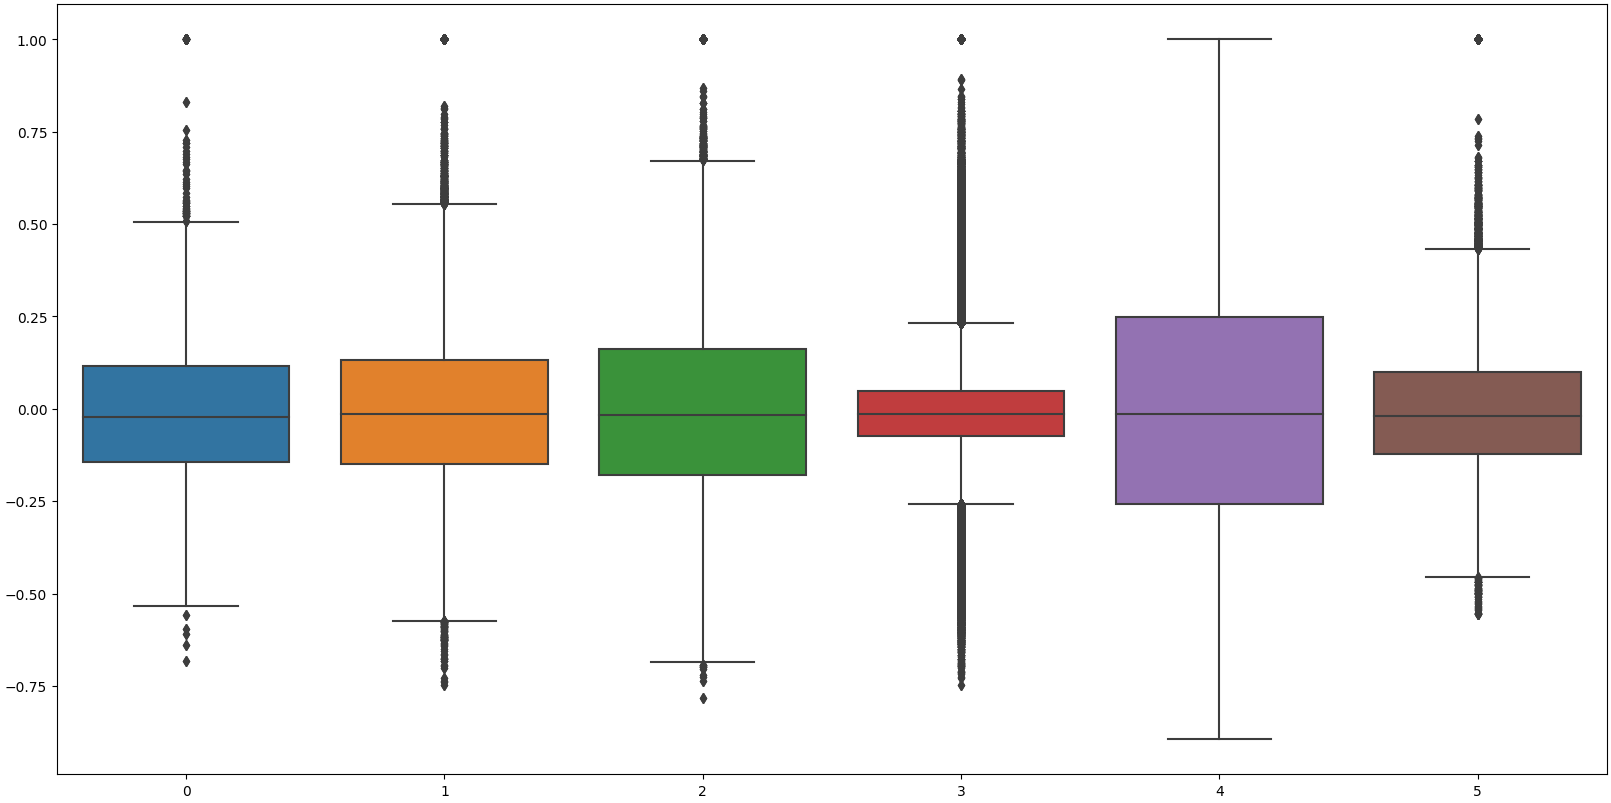

In [199]:
corr_info_per_modality = {m: [] for m in set(id_to_modality.values())}
for id, c in correlations.items():
    m = id_to_modality[id]
    corr_info_per_modality[m] =corr_info_per_modality[m] + (list(c.flatten()))

fig, ax = plt.subplots(figsize=(20,10))
ax = sb.boxplot(list(corr_info_per_modality.values()), ax = ax )


correlations_original = correlations.copy()
for id, c in correlations.items():
    zeros = np.argwhere(c < 0)
    for z_loc in zeros:
        c[z_loc[0], z_loc[1]] = 0
    correlations[id] = c


# removing self-loops
for id in list(optimal_psns.keys()):
    for i in range(len(patients_74)):
        optimal_psns[id][i][i] = 0
        optimal_affs[id][i][i] = 0 
        correlations[id][i][i] = 0 
for id in list(noise_correlations.keys()):
    for i in range(len(patients_74)):
        noise_correlations[id][i][i] = 0
        noise_affs[id][i][i] = 0
        noise_psns[id][i][i] = 0

In [200]:
with open(os.path.join(shared_74, 'correlations.pickle'), 'wb') as f:
    pickle.dump(correlations, f)
with open(os.path.join(shared_74, 'knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_psns, f)
with open(os.path.join(shared_74, 'kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(optimal_affs, f)


with open(os.path.join(shared_74, 'noise_correlations.pickle'), 'wb') as f:
    pickle.dump(noise_correlations, f)
with open(os.path.join(shared_74, 'noise_knn_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_psns, f)
with open(os.path.join(shared_74, 'noise_kernel_PSNs.pickle'), 'wb') as f:
    pickle.dump(noise_affs, f)

In [43]:
with open(os.path.join(shared_74, 'correlations.pickle'), 'rb') as f:
    correlations = pickle.load(f)
with open(os.path.join(shared_74, 'knn_PSNs.pickle'), 'rb') as f:
    optimal_psns = pickle.load(f)
with open(os.path.join(shared_74, 'kernel_PSNs.pickle'), 'rb') as f:
    optimal_affs = pickle.load(f)


with open(os.path.join(shared_74, 'noise_correlations.pickle'), 'rb') as f:
    noise_correlations = pickle.load(f)
with open(os.path.join(shared_74, 'noise_knn_PSNs.pickle'), 'rb') as f:
    noise_psns = pickle.load(f)
with open(os.path.join(shared_74, 'noise_kernel_PSNs.pickle'), 'rb') as f:
    noise_affs = pickle.load(f)

In [176]:
for id, aff in optimal_affs.items():
    graphs_74[id].uns["PSN-kernel"] = aff

for id, psn in optimal_psns.items():
    graphs_74[id].uns["PSN-knn"] = psn

In [177]:
all_psns = list(noise_psns.values()) + list(optimal_psns.values())
all_affs = list(noise_affs.values()) + list(optimal_affs.values()) 
all_feature_matrices = [noise.X for noise in noise_74.values()] + list(id_to_feature_matrices.values()) 
all_correlations = list(noise_correlations.values()) + list(correlations.values())
all_names = list(noise_psns.keys()) + list(optimal_affs.keys()) 

## MoGCN Prepration

In [132]:
mogcn_data_path = os.path.abspath(os.path.join(os.getcwd(),"../../../MoGCN-master/data_shakiba"))
mogcn_data_path

'/Users/shakiba/Desktop/thesis.tmp/MoGCN-master/data_shakiba'

In [133]:
pd.DataFrame(ground_truth_d, index = ["labels"]).T.to_csv(os.path.join(mogcn_data_path, "../labels/gt_d"))
pd.DataFrame(ground_truth_dg, index = ["labels"]).T.to_csv(os.path.join(mogcn_data_path, "../labels/gt_dg"))

In [134]:
for data in graphs_74.values():
    data.to_df().to_csv(os.path.join(mogcn_data_path, data.uns["name"]))

In [131]:
modality_combined = {}

for id, m in id_to_modality.items():
    if m not in list(modality_combined.keys()):
        modality_combined[m] = graphs_74[id].to_df()
    else:
        s = id_to_name[id].split("_")
        modality_combined[m] = modality_combined[m].join(graphs_74[id].to_df(), rsuffix = s )


In [80]:
for id, data in modality_combined.items():
    data.to_csv(os.path.join(mogcn_data_path, id))

## Finding the Weights for the Weighted Average fusion

In [47]:
def weighted_avg_optimize(num_iter, psns):
    adjusted_weights = {}

    score_avg = {}
    fused_graphs_avg = {}

    for iteration in range(num_iter):
        weights = {}
        random_weights = np.random.uniform(low=0, high=10, size=len(psns))
        random_weights = [w/ sum(random_weights) for w in random_weights]
        
        fused_network = 0
        for i, id in enumerate(psns.keys()):
            weights[id] = random_weights[i]
            fused_network = fused_network + weights[id] * psns[id]
          

        transition_matrix = make_transition_matrix(fused_network)
        d_s, dg_s, s = random_walker_objective(transition_matrix)
    
        fused_graphs_avg[iteration] = fused_network
        score_avg[iteration] = s
        adjusted_weights[iteration]  = weights
    

    score_avg = {k: v for k, v in sorted(score_avg.items(), key=lambda item: item[1])} # sort according to scores
    best_iteration_avg = list(score_avg.keys())[-1]
    best_weights_avg = adjusted_weights[best_iteration_avg]
    best_fused_graph_avg = fused_graphs_avg[best_iteration_avg]
    best_score_avg = score_avg[best_iteration_avg]

    return best_score_avg, best_weights_avg, best_fused_graph_avg

In [ ]:
best_aff_score, best_aff_weights, best_wa_aff_graph = weighted_avg_optimize(100000, optimal_affs)

In [25]:
best_pns_score, best_psn_weights, best_wa_psn_graph = weighted_avg_optimize(100000, optimal_psns)

In [130]:
best_noise_score, best_noise_weights, best_wa_noise_graph = weighted_avg_optimize(100000, noise_psns)

In [50]:
best_score_all, best_weights_all, best_wa_graph_all = weighted_avg_optimize(150000, {all_names[i]: all_psns[i] for i in range(len(all_names))})

In [51]:
with open(os.path.join(shared_74, 'weights_modality_frequency.pickle'), 'wb') as f:
    pickle.dump(modality_frequency_weights, f)
with open(os.path.join(shared_74, 'weights_uniform.pickle'), 'wb') as f:
    pickle.dump(weighted_avg_weights, f)
with open(os.path.join(shared_74, 'weights_optimized.pickle'), 'wb') as f:
    pickle.dump(best_psn_weights, f)
with open(os.path.join(shared_74, 'weights_noise.pickle'), 'wb') as f:
    pickle.dump(best_noise_weights, f)
with open(os.path.join(shared_74, 'weights_all.pickle'), 'wb') as f:
    pickle.dump(best_weights_all, f)

In [96]:
with open(os.path.join(shared_74, 'weights_optimized.pickle'), 'rb') as f:
    best_psn_weights = pickle.load(f)

with open(os.path.join(shared_74, 'weights_noise.pickle'), 'rb') as f:
    best_noise_weights = pickle.load(f)

with open(os.path.join(shared_74, 'weights_all.pickle'), 'rb') as f:
    best_weights_all = pickle.load(f)

## Labels

### Kernel + SNF

In [178]:
# No noise
fused = compute.snf(list(optimal_affs.values()), K=best_kernel["k"], t = 60) # k = 6

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel = list(ad_snf_kernel.obs.leiden)

In [179]:
# Only noise
fused = compute.snf(list(noise_affs.values()), K=best_kernel["k"], t = 60) # k = 6

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel_noise = list(ad_snf_kernel.obs.leiden)

In [180]:
# Both noise and original graphs
fused = compute.snf(all_affs, K=best_kernel["k"], t = 60) # k = 6 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_kernel_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_kernel =ad.AnnData(fused)
ad_snf_kernel.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_kernel, resolution=0.25, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_kernel_all = list(ad_snf_kernel.obs.leiden)


In [181]:
# Single PSNs, Spectral Clustering
labels_kernel_psn_sc = {}

for i in range(len(all_names)):
    name = all_names[i] 
    psn = all_affs[i]
    
    first, second = compute.get_n_clusters(psn)
    labels_sc_kernel = cluster.spectral_clustering(psn, n_clusters=first, n_init = 40)

    labels_kernel_psn_sc[name] = labels_sc_kernel


/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)
/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_inf

### KNN + WA

In [182]:
# Non Noise
fused = None
for id in best_psn_weights.keys():
    if fused is None:
        fused = optimal_psns[id] * best_psn_weights[id]
    else:
        fused = fused + optimal_psns[id] * best_psn_weights[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)


first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)
        
ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn = list(ad_wa_knn.obs.leiden)

In [183]:
# Noise only
fused = None
for id in best_noise_weights.keys():
    if fused is None:
        fused = noise_psns[id] * best_noise_weights[id]
    else:
        fused = fused + noise_psns[id] * best_noise_weights[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)

first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn_noise = list(ad_wa_knn.obs.leiden)

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [184]:
# Both noise and original 
fused = None
all_dict =  {all_names[i]: all_psns[i] for i in range(len(all_names))}
for id in best_weights_all.keys():
    if fused is None:
        fused = all_dict[id] * best_weights_all[id]
    else:
        fused = fused + all_dict[id] * best_weights_all[id]

if np.isnan(fused).any():
    nan_locs = np.argwhere(np.isnan(fused))
    for loc in nan_locs:
        fused[loc[0], loc[1]] = 0
    print(np.isnan(fused).any() == False)

first, second = compute.get_n_clusters(fused)
labels_sc_wa_knn_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_wa_knn =ad.AnnData(fused)
ad_wa_knn.obsp["connectivities"] = fused
scp.tl.leiden(ad_wa_knn, resolution=1, adjacency=fused, directed=False, use_weights=True)
labels_leiden_wa_knn_all = list(ad_wa_knn.obs.leiden)

/Users/shakiba/Desktop/thesis.tmp/code/aggregated_patient_info/aggregated_patient_info/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:247: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  adjacency = check_symmetric(adjacency)


In [185]:
# Single PSNs, Leiden
labels_knn_psn_leiden = {}

for name in all_names:
    if name in list(noise_74.keys()):
        psn = noise_74[name]
    else:
        psn = graphs_74[name]
    
    scp.pp.neighbors(psn, n_neighbors = 6, use_rep='X')
    scp.tl.leiden(psn, resolution=1, directed=False, use_weights=True)
    labels_knn_psn_leiden[name] = list(psn.obs.leiden)


### Corr + SNF

In [186]:
# Non noise
fused = compute.snf(list(correlations.values()), K=6, t = 60) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr = ad_snf_corr.obs.leiden

In [187]:
# Noise
fused = compute.snf(list(noise_correlations.values()), K=6, t = 60) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr_noise = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr_noise = ad_snf_corr.obs.leiden

In [188]:
# Noise and original
fused = compute.snf(all_correlations, K=6, t = 60) 

first, second = compute.get_n_clusters(fused)
labels_sc_snf_corr_all = cluster.spectral_clustering(fused, n_clusters=first, n_init = 40)

ad_snf_corr =ad.AnnData(fused)
ad_snf_corr.obsp["connectivities"] = fused
scp.tl.leiden(ad_snf_corr, resolution=0.666, adjacency=fused, directed=False, use_weights=True)
labels_leiden_snf_corr_all = ad_snf_corr.obs.leiden

### Concat + KNN

In [189]:
fused = np.concatenate(list(id_to_feature_matrices.values()), axis = 1)
ad_concat = ad.AnnData(fused)
scp.pp.neighbors(ad_concat, n_neighbors = 6, use_rep='X', metric = "seuclidean" , method = "umap", knn = True ) 

In [190]:
scp.tl.leiden(ad_concat, resolution=1.025, directed=False, use_weights=True)

In [191]:
labels_leiden_concat = ad_concat.obs.leiden

### Saving

In [192]:
labels = {"leiden_concat": labels_leiden_concat, "leiden_snf_corr": labels_leiden_snf_corr, "sc_snf_corr": labels_sc_snf_corr, "leiden_wa_knn": labels_leiden_wa_knn, "sc_wa_knn": labels_sc_wa_knn, "leiden_snf_kernel": labels_leiden_snf_kernel, "sc_snf_kernel": labels_sc_snf_kernel, "ground_truth_d": ground_truth_d, "ground_truth_dg": ground_truth_dg,  "noise_leiden_snf_corr": labels_leiden_snf_corr_noise, "noise_sc_snf_corr": labels_sc_snf_corr_noise, "noise_leiden_wa_knn": labels_leiden_wa_knn_noise, "noise_sc_wa_knn": labels_sc_wa_knn_noise, "noise_leiden_snf_kernel": labels_leiden_snf_kernel_noise, "noise_sc_snf_kernel": labels_sc_snf_kernel_noise, "all_leiden_snf_corr": labels_leiden_snf_corr_all, "all_sc_snf_corr": labels_sc_snf_corr_all, "all_leiden_wa_knn": labels_leiden_wa_knn_all, "all_sc_wa_knn": labels_sc_wa_knn_all, "all_leiden_snf_kernel": labels_leiden_snf_kernel_all, "all_sc_snf_kernel": labels_sc_snf_kernel_all }

In [193]:
all_dict = {"all_psns": all_psns, "all_affs": all_affs, "all_feature_matrices": all_feature_matrices,  "all_correlations": all_correlations, "all_names":all_names}

In [194]:
with open(os.path.join(shared_74, 'labels.pickle'), 'wb') as f:
    pickle.dump(labels, f)

with open(os.path.join(shared_74, 'all_dict.pickle'), 'wb') as f:
    pickle.dump(all_dict, f)

with open(os.path.join(shared_74, 'labels_kernel_psn_sc.pickle'), 'wb') as f:
    pickle.dump(labels_kernel_psn_sc, f)

with open(os.path.join(shared_74, 'labels_knn_psn_leiden.pickle'), 'wb') as f:
    pickle.dump(labels_knn_psn_leiden, f)

# lll

## Ranking the Contribution based on LOO on PSN and Aff with SNF

In [ ]:
# The three scores for the full SNF fusion on affinities
labels = list(snf_fused.obs.leiden_kernel)
X = snf_fused.uns['fused-kernel']

# silhouette score is a metric used to calculate the goodness of a clustering technique. Its value ranges from -1 to 1.
#1: Means clusters are well apart from each other and clearly distinguished.
#0: Means clusters are indifferent, or we can say that the distance between clusters is not significant.
#-1: Means clusters are assigned in the wrong way. 
# https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c#:~:text=Silhouette%20Coefficient%20or%20silhouette%20score%20is%20a%20metric%20used%20to,each%20other%20and%20clearly%20distinguished.
silhouette_score_all_aff = skl.metrics.silhouette_score(X, labels)
davies_bouldin_score_all_aff = skl.metrics.davies_bouldin_score(X, labels)

tm = make_transition_matrix(X)
score_all_aff = random_walker_objective(tm)[2]

print(silhouette_score_all_aff, davies_bouldin_score_all_aff,  score_all_aff)

-0.021358430410949637 3.8441934840939043 4.536852310489391


## Ranking the Contribution based on Normalized Mutual Information on Aff with SNF 

### ToDo - Weighted Average

### SNF with Kernel PSNs and Spectral Clustering

In [ ]:
# compute adjusted mutual information for clustering solutions
labels = [list(ground_truth_d.values()), list(sc_kernel_labels["snf_fused"]), list(sc_kernel_labels["wa_fused"])] 
for id in list(id_to_graphs_with_74_nodes.keys())[:-2]:
     labels.append(list(sc_kernel_labels[id]))

ami_sc_kernel = []
for l1 in labels:
     l1_amis = []
     for l2 in labels:
          l1_amis.append(ami(l1,l2))
     ami_sc_kernel.append(l1_amis)

In [ ]:
# Marking contributions as high or low, through comparing contribution to ground truth with contribution to fused network clustering
ami_sc_kernel_df = pd.DataFrame({"ground_truth": ami_sc_kernel[0],
"snf": ami_sc_kernel[1], "count": [i for i in range(len(ami_sc_kernel[0])) ] }, index = (["gound truth", "snf-fused network", "wa-fused network"] + list(id_to_graphs_with_74_nodes.keys())[:-2]))

In [ ]:
ami_sc_kernel_df.drop("wa-fused network", inplace = True)
ami_sc_kernel_df["count"] = range(len(ami_sc_kernel_df.index))

contribution = ["equal", "equal"]
for row in list(ami_sc_kernel_df.index)[2:]:
    gt_l = ami_sc_kernel_df.loc[row]["ground_truth"]
    l_l = ami_sc_kernel_df.loc[row]["snf"]
    if abs(gt_l - l_l) <= 0.02:
        contribution.append("equal")
    elif gt_l - l_l > 0:
        contribution.append("low")
    else:
        contribution.append("high")

<Axes: >

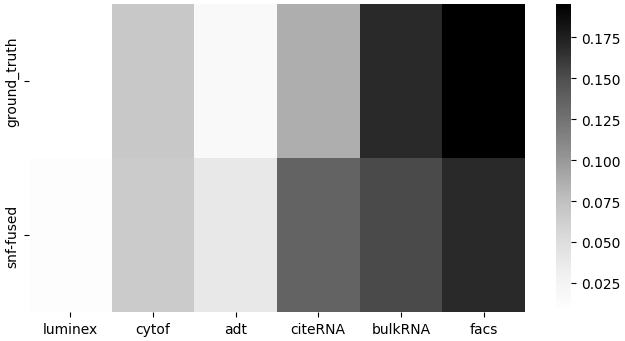

In [ ]:
# Average Contribution per modality
ami_sc_kernel_df_new = ami_sc_kernel_df.drop(['gound truth',"snf-fused network"], axis = 0, inplace = False )

modality_contributions_ground_truth = {m: 0 for m in set(id_to_modality.values()) if m != "fused"}
modality_contributions_sc_kernel = {m: 0 for m in set(id_to_modality.values()) if m != "fused"}
modality_counts = {m: 0 for m in set(id_to_modality.values()) if m != "fused"}

for id in ami_sc_kernel_df_new.index:
    m = id_to_modality[id]
    modality_contributions_ground_truth[m]+= ami_sc_kernel_df_new.loc[id, "ground_truth"]
    modality_contributions_sc_kernel[m] += ami_sc_kernel_df_new.loc[id, "snf"]
    modality_counts[m] += 1

for m in modality_contributions_ground_truth:
    modality_contributions_ground_truth[m] = modality_contributions_ground_truth[m] / modality_counts[m]
    modality_contributions_sc_kernel[m] = modality_contributions_sc_kernel[m] / modality_counts[m]


fig, ax = plt.subplots(figsize=(8,4))
sb.heatmap( pd.DataFrame.from_dict({"ground_truth": modality_contributions_ground_truth, "snf-fused": modality_contributions_sc_kernel}).transpose(), cmap = "Greys", vmax = pd.DataFrame.from_dict({"ground_truth": modality_contributions_ground_truth, "snf-fused": modality_contributions_sc_kernel}).max().max(), ax = ax)

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_81419/407887157.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  process = module_names[module_names["cell_type"] == cell_type][module_names["module"] == module]["name"]


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


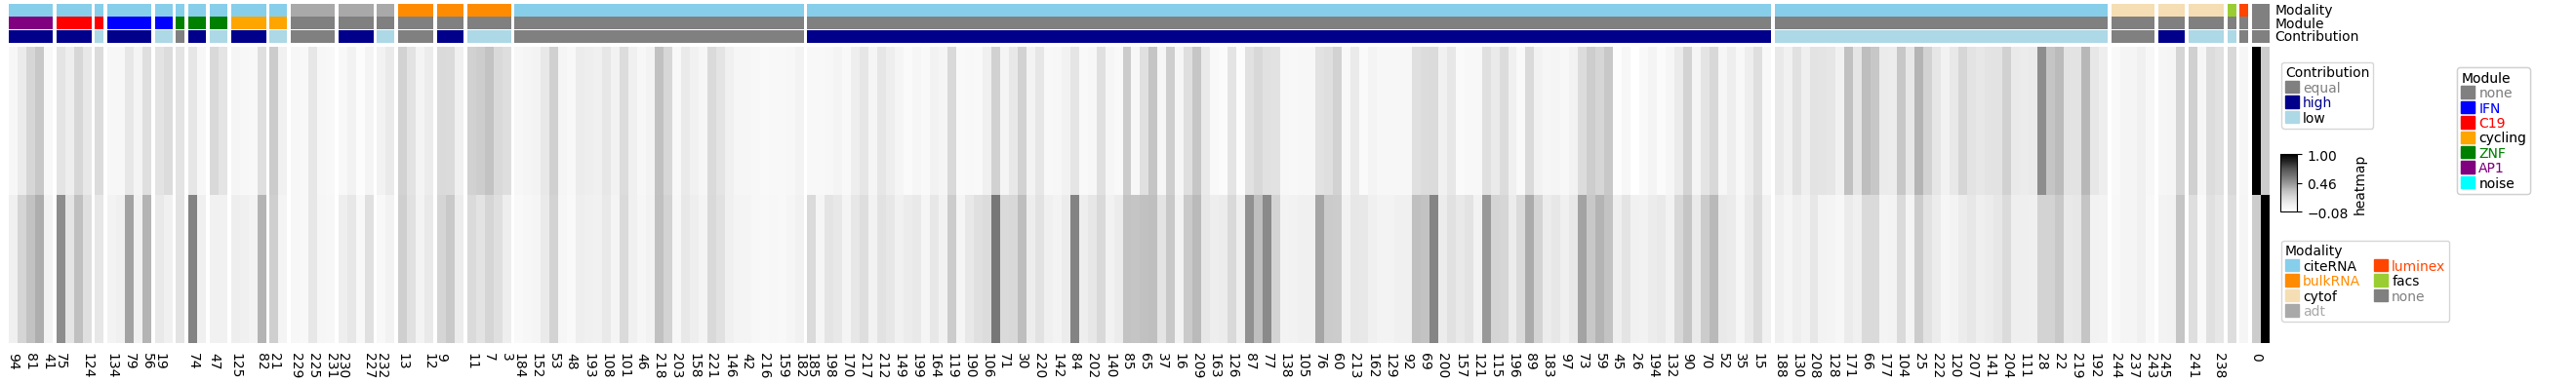

In [ ]:
# Contribution per graph (seperate) 

number_to_modality_new = {}
number_to_module_new = {}
number_to_contribution = {}


for i, id in enumerate(ami_sc_kernel_df.index):
    if id == "gound truth" or id == "snf-fused network":
        modality = "none"
        process = "none"
        
    else:
        name = id_to_name[id]
    
        modality = name.split("_")[0]
        if modality == "citeRNA":
            cell_type = name.split("_")[1].split("-")[0]
            module = name.split("-")[1]
            process = module_names[module_names["cell_type"] == cell_type][module_names["module"] == module]["name"]
            if len(process) == 0:
                process = "none"
            else:
                process = list(process)[0]
            
        else:
            process = "none"

    number_to_modality_new[i] = modality
    number_to_module_new[i] = process
    number_to_contribution[i] = contribution[i]


df_column = pd.DataFrame(number_to_modality_new.values(), columns=["modality"]).join(pd.DataFrame(number_to_module_new.values(), columns=["module"])).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"]))


col_colors_dict = {"module":{"none": "grey", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen", "none": "grey" },
                    "contribution": {"equal": "grey", "high": "darkblue", "low":"lightblue"}  }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Module=anno_simple(df_column.module,colors=col_colors_dict['module'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)

ami_df_new_index = ami_sc_kernel_df.set_index("count") # We need an integer index

fig, ax = plt.subplots(figsize=(30,4))
ami_kernel_plt = ClusterMapPlotter(data=ami_df_new_index.transpose(), top_annotation=col_ha,
                     show_rownames=False,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, ['module', 'modality', "contribution"]],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5, )

### SNF with Kernel PSNs and Leiden Clustering

In [ ]:
# compute adjusted mutual information for clustering solutions
labels = [list(ground_truth_d.values()), list(leiden_kernel_labels["snf_fused"]), list(leiden_kernel_labels["wa_fused"])] 
for id in list(id_to_graphs_with_74_nodes.keys())[:-2]:
     labels.append(list(leiden_kernel_labels[id]))

ami_leiden_kernel = []
for l1 in labels:
     l1_amis = []
     for l2 in labels:
          l1_amis.append(ami(l1,l2))
     ami_leiden_kernel.append(l1_amis)

In [ ]:
# Marking contributions as high or low, through comparing contribution to ground truth with contribution to fused network clustering
ami_leiden_kernel_df = pd.DataFrame({"ground_truth": ami_leiden_kernel[0],
"snf": ami_leiden_kernel[1], "count": [i for i in range(len(ami_leiden_kernel[0])) ] }, index = (["gound truth", "snf-fused network", "wa-fused network"] + list(id_to_graphs_with_74_nodes.keys())[:-2]))

In [ ]:
ami_leiden_kernel_df.drop("wa-fused network", inplace = True)
ami_leiden_kernel_df["count"] = range(len(ami_leiden_kernel_df.index))


contribution = ["equal", "equal"]
for row in list(ami_leiden_kernel_df.index)[2:]:
    gt_l = ami_leiden_kernel_df.loc[row]["ground_truth"]
    l_l = ami_leiden_kernel_df.loc[row]["snf"]
    if abs(gt_l - l_l) <= 0.04:
        contribution.append("equal")
    elif gt_l - l_l > 0:
        contribution.append("low")
    else:
        contribution.append("high")

<Axes: >

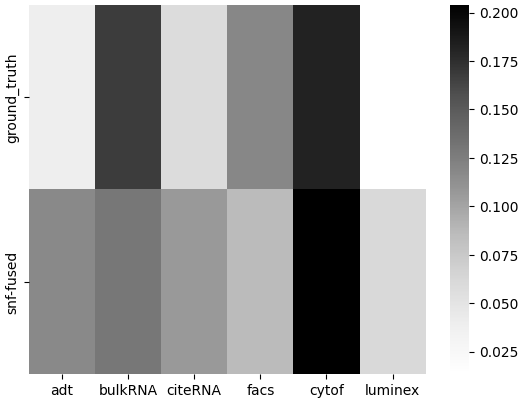

In [ ]:
# Average Contribution per modality
ami_leiden_kernel_df_new = ami_leiden_kernel_df.drop(['gound truth',"snf-fused network"], axis = 0, inplace = False )

modality_contributions_ground_truth = {m: 0 for m in set(id_to_modality.values()) if m != "fused"}
modality_contributions_leiden_kernel = {m: 0 for m in set(id_to_modality.values()) if m != "fused"}
modality_counts = {m: 0 for m in set(id_to_modality.values()) if m != "fused"}

for id in ami_leiden_kernel_df_new.index:
    m = id_to_modality[id]
    modality_contributions_ground_truth[m]+= ami_leiden_kernel_df_new.loc[id, "ground_truth"]
    modality_contributions_leiden_kernel[m] += ami_leiden_kernel_df_new.loc[id, "snf"]
    modality_counts[m] += 1

for m in modality_contributions_ground_truth:
    modality_contributions_ground_truth[m] = modality_contributions_ground_truth[m] / modality_counts[m]
    modality_contributions_leiden_kernel[m] = modality_contributions_leiden_kernel[m] / modality_counts[m]

sb.heatmap(pd.DataFrame.from_dict({"ground_truth": modality_contributions_ground_truth, "snf-fused": modality_contributions_leiden_kernel}).transpose(), cmap = "Greys")

/var/folders/d6/19fjtfkn2rb94y09ln9bk6m00000gn/T/ipykernel_57369/2545190162.py:20: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  process = module_names[module_names["cell_type"] == cell_type][module_names["module"] == module]["name"]


Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..
Starting plotting HeatmapAnnotations
Plotting legends..
Incresing ncol
Incresing ncol
Incresing ncol
More than 3 cols is not supported
Legend too long, generating a new column..


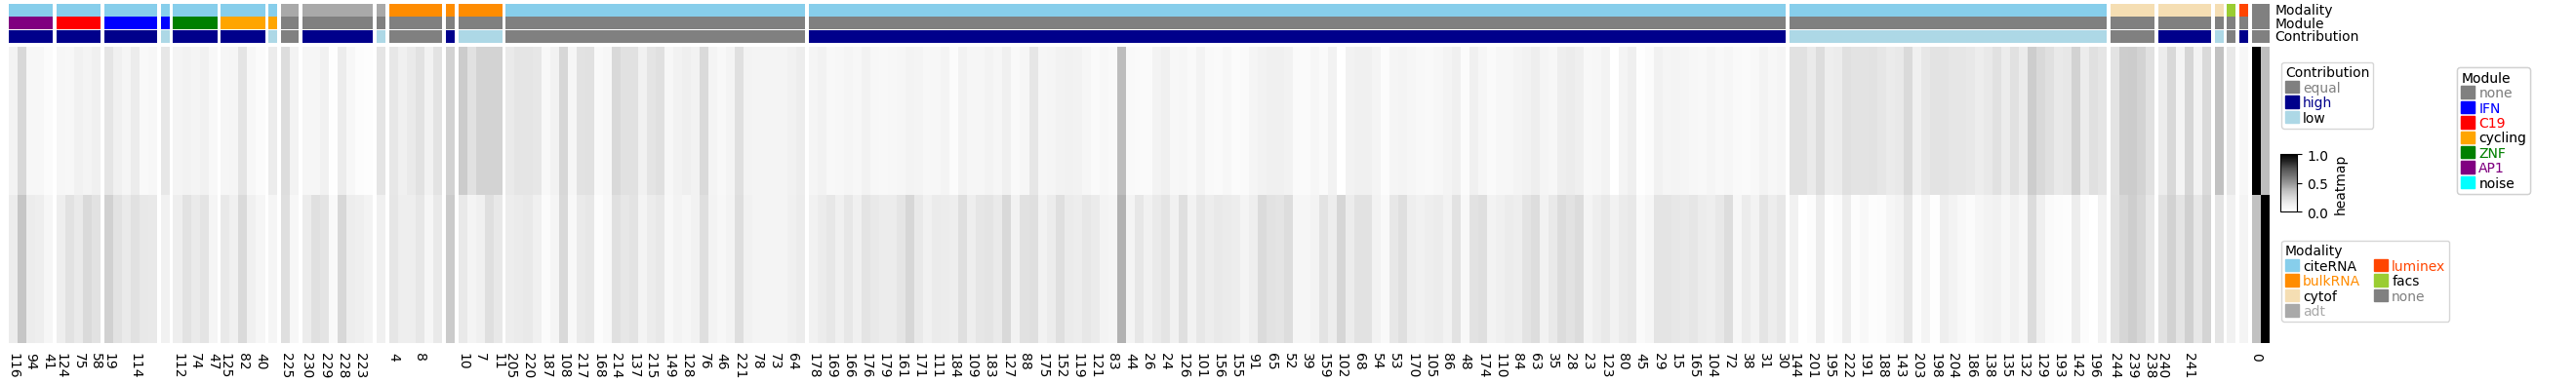

In [ ]:
# Contribution per graph (seperate) 

number_to_modality_new = {}
number_to_module_new = {}
number_to_contribution = {}


for i, id in enumerate(ami_leiden_kernel_df.index):
    if id == "gound truth" or id == "snf-fused network":
        modality = "none"
        process = "none"
        
    else:
        name = id_to_name[id]
    
        modality = name.split("_")[0]
        if modality == "citeRNA":
            cell_type = name.split("_")[1].split("-")[0]
            module = name.split("-")[1]
            process = module_names[module_names["cell_type"] == cell_type][module_names["module"] == module]["name"]
            if len(process) == 0:
                process = "none"
            else:
                process = list(process)[0]
            
        else:
            process = "none"

    number_to_modality_new[i] = modality
    number_to_module_new[i] = process
    number_to_contribution[i] = contribution[i]


df_column = pd.DataFrame(number_to_modality_new.values(), columns=["modality"]).join(pd.DataFrame(number_to_module_new.values(), columns=["module"])).join(pd.DataFrame(number_to_contribution.values(), columns=["contribution"]))


col_colors_dict = {"module":{"none": "grey", "IFN": "blue", "C19": "red", "cycling": "orange", "ZNF": "green", "AP1": "purple", "noise": "cyan" },
                  "modality":{"citeRNA":"skyblue", "bulkRNA": "darkorange" , "cytof": "wheat", "adt": "darkgray", "luminex": "orangered", "facs": "yellowgreen", "none": "grey" },
                    "contribution": {"equal": "grey", "high": "darkblue", "low":"lightblue"}  }


col_ha= HeatmapAnnotation(Modality=anno_simple(df_column.modality,colors=col_colors_dict['modality'],rasterized=True),
                          Module=anno_simple(df_column.module,colors=col_colors_dict['module'],rasterized=True),
                          Contribution=anno_simple(df_column.contribution,colors=col_colors_dict['contribution'],rasterized=True),
                          axis=1)

ami_leiden_kernel_df_new_index = ami_leiden_kernel_df.set_index("count") # We need an integer index
ami_leiden_kernel_df_new_index = pd.DataFrame(min_max_scalar.fit_transform(ami_leiden_kernel_df_new_index), index = ami_leiden_kernel_df["count"], columns =  ["ground_truth", "snf"] )

fig, ax = plt.subplots(figsize=(30,4))
ami_kernel_plt = ClusterMapPlotter(data=ami_leiden_kernel_df_new_index.transpose(), top_annotation=col_ha,
                     show_rownames=False,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     col_split=df_column.loc[:, ['module', 'modality', "contribution"]],
                     cmap='Greys',
                     rasterized=True,col_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5, )

### Contribution of features

In [ ]:
inputs =  [(m, "sqeuclidean") for m in feature_matrices.values()]
nmi = [np.empty(shape=(d.shape[-1])) for d, m in inputs]
for ndtype, (dtype, metric) in enumerate(inputs):
    for nfeature, feature in enumerate(np.asarray(dtype).T):
        aff = compute.make_affinity(np.vstack(feature), K=4, mu=0.4, metric=metric)
            
        aff_labels = cluster.spectral_clustering(aff, n_clusters=first)
        nmi[ndtype][nfeature] = v_measure_score(fused_labels, aff_labels)
    print(ndtype)

In [ ]:
top_5pct_features_contibuting_via_v_measure = {}
low_5pct_features_contibuting_via_v_measure = {}

for i, g in enumerate(feature_matrices.keys()):
    name = id_to_name[g]
    feature_nmi = nmi[i]
    t_high = np.percentile(feature_nmi, 95)
    t_low = np.percentile(feature_nmi, 5)
    all_features = graphs_with_74_nodes_dict[g].var_names
    top_5pct_features_contibuting_via_v_measure[name] = []
    low_5pct_features_contibuting_via_v_measure[name] = []
    for j, f in enumerate(feature_nmi):
        if f >= t_high:
            top_5pct_features_contibuting_via_v_measure[name].append(all_features[j])
        if f <= t_low:
            low_5pct_features_contibuting_via_v_measure[name].append(all_features[j])

In [ ]:
inputs =  [(m, "sqeuclidean") for m in feature_matrices.values()]
feature_ami = [np.empty(shape=(d.shape[-1])) for d, m in inputs]
for ndtype, (dtype, metric) in enumerate(inputs):
    for nfeature, feature in enumerate(np.asarray(dtype).T):
        aff = compute.make_affinity(np.vstack(feature), K=4, mu=0.4, metric=metric)
            
        aff_labels = cluster.spectral_clustering(aff, n_clusters=first)
        feature_ami[ndtype][nfeature] = ami(fused_labels, aff_labels)
    print(ndtype)

## Analysis of Contributions

In [ ]:
top_5pct_Affgraphs_contibuting_to_ground_truth_via_ami = []
low_5pct_Affgraphs_contibuting_to_ground_truth_via_ami = []

t_high = np.percentile(ami_sc_kernel[0][3:], 95)
t_low = np.percentile(ami_sc_kernel[0][3:], 5)

for i, value in enumerate(ami_sc_kernel[0][3:]):
    graph_id = list(id_to_graphs_with_74_nodes.keys())[i]
    name = id_to_name[graph_id]
    if value <= t_low:
        low_5pct_Affgraphs_contibuting_to_ground_truth_via_ami.append(name)
    if value >= t_high:
        top_5pct_Affgraphs_contibuting_to_ground_truth_via_ami.append(name)

In [ ]:
low_5pct_Affgraphs_contibuting_to_spectral_clustering_via_ami = []
top_5pct_Affgraphs_contibuting_to_spectral_clustering_via_ami = []

t_high = np.percentile(ami_sc_kernel[1][3:], 95)
t_low = np.percentile(ami_sc_kernel[1][3:], 5)

for i, value in enumerate(ami_sc_kernel[1][3:]):
    graph_id = list(id_to_graphs_with_74_nodes.keys())[i]
    name = id_to_name[graph_id]
    if value <= t_low:
        low_5pct_Affgraphs_contibuting_to_spectral_clustering_via_ami.append(name)
    if value >= t_high:
        top_5pct_Affgraphs_contibuting_to_spectral_clustering_via_ami.append(name)

In [ ]:
low_5pct_Affgraphs_contibuting_to_leiden_clustering_via_ami = []
top_5pct_Affgraphs_contibuting_to_leiden_clustering_via_ami = []

t_high = np.percentile(ami_leiden_kernel[1][3:], 95)
t_low = np.percentile(ami_leiden_kernel[1][3:], 5)

for i, value in enumerate(ami_leiden_kernel[1][3:]):
    graph_id = list(id_to_graphs_with_74_nodes.keys())[i]
    name = id_to_name[graph_id]
    if value <= t_low:
        low_5pct_Affgraphs_contibuting_to_leiden_clustering_via_ami.append(name)
    if value >= t_high:
        top_5pct_Affgraphs_contibuting_to_leiden_clustering_via_ami.append(name)

In [ ]:
top_5pct_PSNgraphs_closeness_to_opt = []
low_5pct_PSNgraphs_closeness_to_opt = []

t_high = np.percentile(list(rw_scores_psns.values()), 95)
t_low = np.percentile(list(rw_scores_psns.values()), 5)

for k,v in rw_scores_psns.items():
    if v >= t_high:
        top_5pct_PSNgraphs_closeness_to_opt.append(id_to_name[k])
    if v <= t_low:
        low_5pct_PSNgraphs_closeness_to_opt.append(id_to_name[k])

In [ ]:
top_5pct_Affgraphs_closeness_to_opt = []
low_5pct_Affgraphs_closeness_to_opt = []

t_high = np.percentile(list(rw_scores_aff.values()), 95)
t_low = np.percentile(list(rw_scores_aff.values()), 5)

for k,v in rw_scores_psns.items():
    if v >= t_high:
        top_5pct_Affgraphs_closeness_to_opt.append(id_to_name[k])
    if v <= t_low:
        low_5pct_Affgraphs_closeness_to_opt.append(id_to_name[k])

In [ ]:
low_5pct_PSNgraphs_contibuting_to_random_walk = []
top_5pct_PSNgraphs_contibuting_to_random_walk = []

normalized_rw_scores = min_max_scalar.fit_transform(np.array(list(score_psns.values()), dtype= "float64").reshape(1,-1))

t_high = np.percentile(normalized_rw_scores, 95)
t_low = np.percentile(normalized_rw_scores, 5)

for i, k in enumerate(score_psns.keys()):
    v = normalized_rw_scores[0][i]
    if v >= t_high:
        top_5pct_PSNgraphs_contibuting_to_random_walk.append(id_to_name[k])
    if v <= t_low:
        low_5pct_PSNgraphs_contibuting_to_random_walk.append(id_to_name[k])

# Controls

## Negative Control

In [ ]:
for i, g in enumerate(noise_graphs_with_74_nodes):
    if i < 25:
        np.random.shuffle(g.X)
        name = g.uns["name"]
        id = "N" + str(i)
        name_to_id[name] = id
        id_to_name[id] = name
        g.uns["id"] = id
        noise_graphs_with_74_nodes[i] = g

In [ ]:
all_noise = {g.uns["id"]: g for g in noise_graphs_with_74_nodes[:25]}
grey_noise = {g.uns["id"]: g for g in noise_graphs_with_74_nodes[:25] if g.uns["name"].find("grey") >= 0}
non_noise = graphs_with_74_nodes_dict.copy()
all_anndata = all_noise | non_noise


all_noise_psns = {g.uns["id"]:  knn(g, best_knn["k"], best_knn["metric"], best_knn["method"]) for g in noise_graphs_with_74_nodes[:25]}
grey_noise_psns = {g.uns["id"]:  knn(g, best_knn["k"], best_knn["metric"], best_knn["method"]) for g in noise_graphs_with_74_nodes[:25] if g.uns["name"].find("grey") >= 0}
non_noise_psns = optimal_psns.copy()
all_psns = all_noise_psns | non_noise_psns


all_noise_aff = {g.uns["id"] :  compute.make_affinity(g.X, metric=best_kernel["metric"], K= best_kernel["k"], mu=best_kernel["mu"], normalize = False) for g in noise_graphs_with_74_nodes[:25]}
grey_noise_aff = {g.uns["id"] :  compute.make_affinity(g.X, metric=best_kernel["metric"], K= best_kernel["k"], mu=best_kernel["mu"], normalize = False) for g in noise_graphs_with_74_nodes[:25] if g.uns["name"].find("grey") >= 0}
non_noise_aff = optimal_affs.copy()
all_aff = all_noise_aff | non_noise_aff

In [ ]:
weighted_avg_fusion_all_psns = weighted_avg_optimize(100000, all_psns)[2]
weighted_avg_fusion_all_aff = weighted_avg_optimize(100000, all_aff)[2]

#weighted_avg_fusion_noise_psns = weighted_avg_optimize(num_iter = 100000, matrices = grey_noise_psns)
#weighted_avg_fusion_noise_aff = weighted_avg_optimize(num_iter = 100000, matrices = grey_noise_aff)

weighted_avg_non_noise_psns =  id_to_graphs_with_74_nodes["wa_fused"].uns["fused-knn"]
weighted_avg_non_noise_aff = id_to_graphs_with_74_nodes["wa_fused"].uns["fused-kernel"]

In [ ]:
snf_fusion_all_psns = compute.snf(list(all_psns.values()), K=best_kernel["k"], t = 40)
snf_fusion_all_aff = compute.snf(list(all_aff.values()), K=best_kernel["k"], t = 40)


#snf_fusion_noise_psns = fusion_snf(grey_noise_psns, k = 4)
#snf_fusion_noise_aff = fusion_snf(grey_noise_aff, k = 4)

snf_non_noise_psns = id_to_graphs_with_74_nodes["snf_fused"].uns["fused-knn"]
snf_non_noise_aff = id_to_graphs_with_74_nodes["snf_fused"].uns["fused-kernel"]

In [ ]:
tm_all_psns_wa = make_transition_matrix(weighted_avg_fusion_all_psns)
tm_all_aff_wa = make_transition_matrix(weighted_avg_fusion_all_aff)

#tm_noise_psns_wa = make_transition_matrix(weighted_avg_fusion_noise_psns[2].X)
#tm_noise_aff_wa = make_transition_matrix(weighted_avg_fusion_noise_aff[2].X)

tm_non_noise_psns_wa = make_transition_matrix(weighted_avg_non_noise_psns) 
tm_non_noise_aff_wa = make_transition_matrix(weighted_avg_non_noise_aff) 

In [ ]:
tm_all_psns_snf = make_transition_matrix(snf_fusion_all_psns) 
tm_all_aff_snf = make_transition_matrix(snf_fusion_all_aff)  

#tm_noise_psns_snf = make_transition_matrix(snf_fusion_noise_psns.X) 
#tm_noise_aff_snf = make_transition_matrix(snf_fusion_noise_aff.X)  

tm_non_noise_psns_snf = make_transition_matrix(snf_non_noise_psns) 
tm_non_noise_aff_snf = make_transition_matrix(snf_non_noise_aff)  

### PSNs

In [ ]:
forb_norm = []

for i, g1 in enumerate(id_to_graphs_with_74_nodes.keys()):
    forb_norm_with_g1 = []

    if g1 != "snf_fused" and g1 != "wa_fused":
        g1 = optimal_psns[g1].copy()
    else:
        continue
    for j, g2 in enumerate(id_to_graphs_with_74_nodes.keys()):
        if g2 != "snf_fused" and g2 != "wa_fused":
            g2 = optimal_psns[g2].copy()
        else:
            continue

        diff = g1 - g2
        norm = np.linalg.norm(diff)
        forb_norm_with_g1.append(norm)

    forb_norm.append(forb_norm_with_g1)

forb_norm = np.array(forb_norm)
forb_norm_df = pd.DataFrame(forb_norm)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


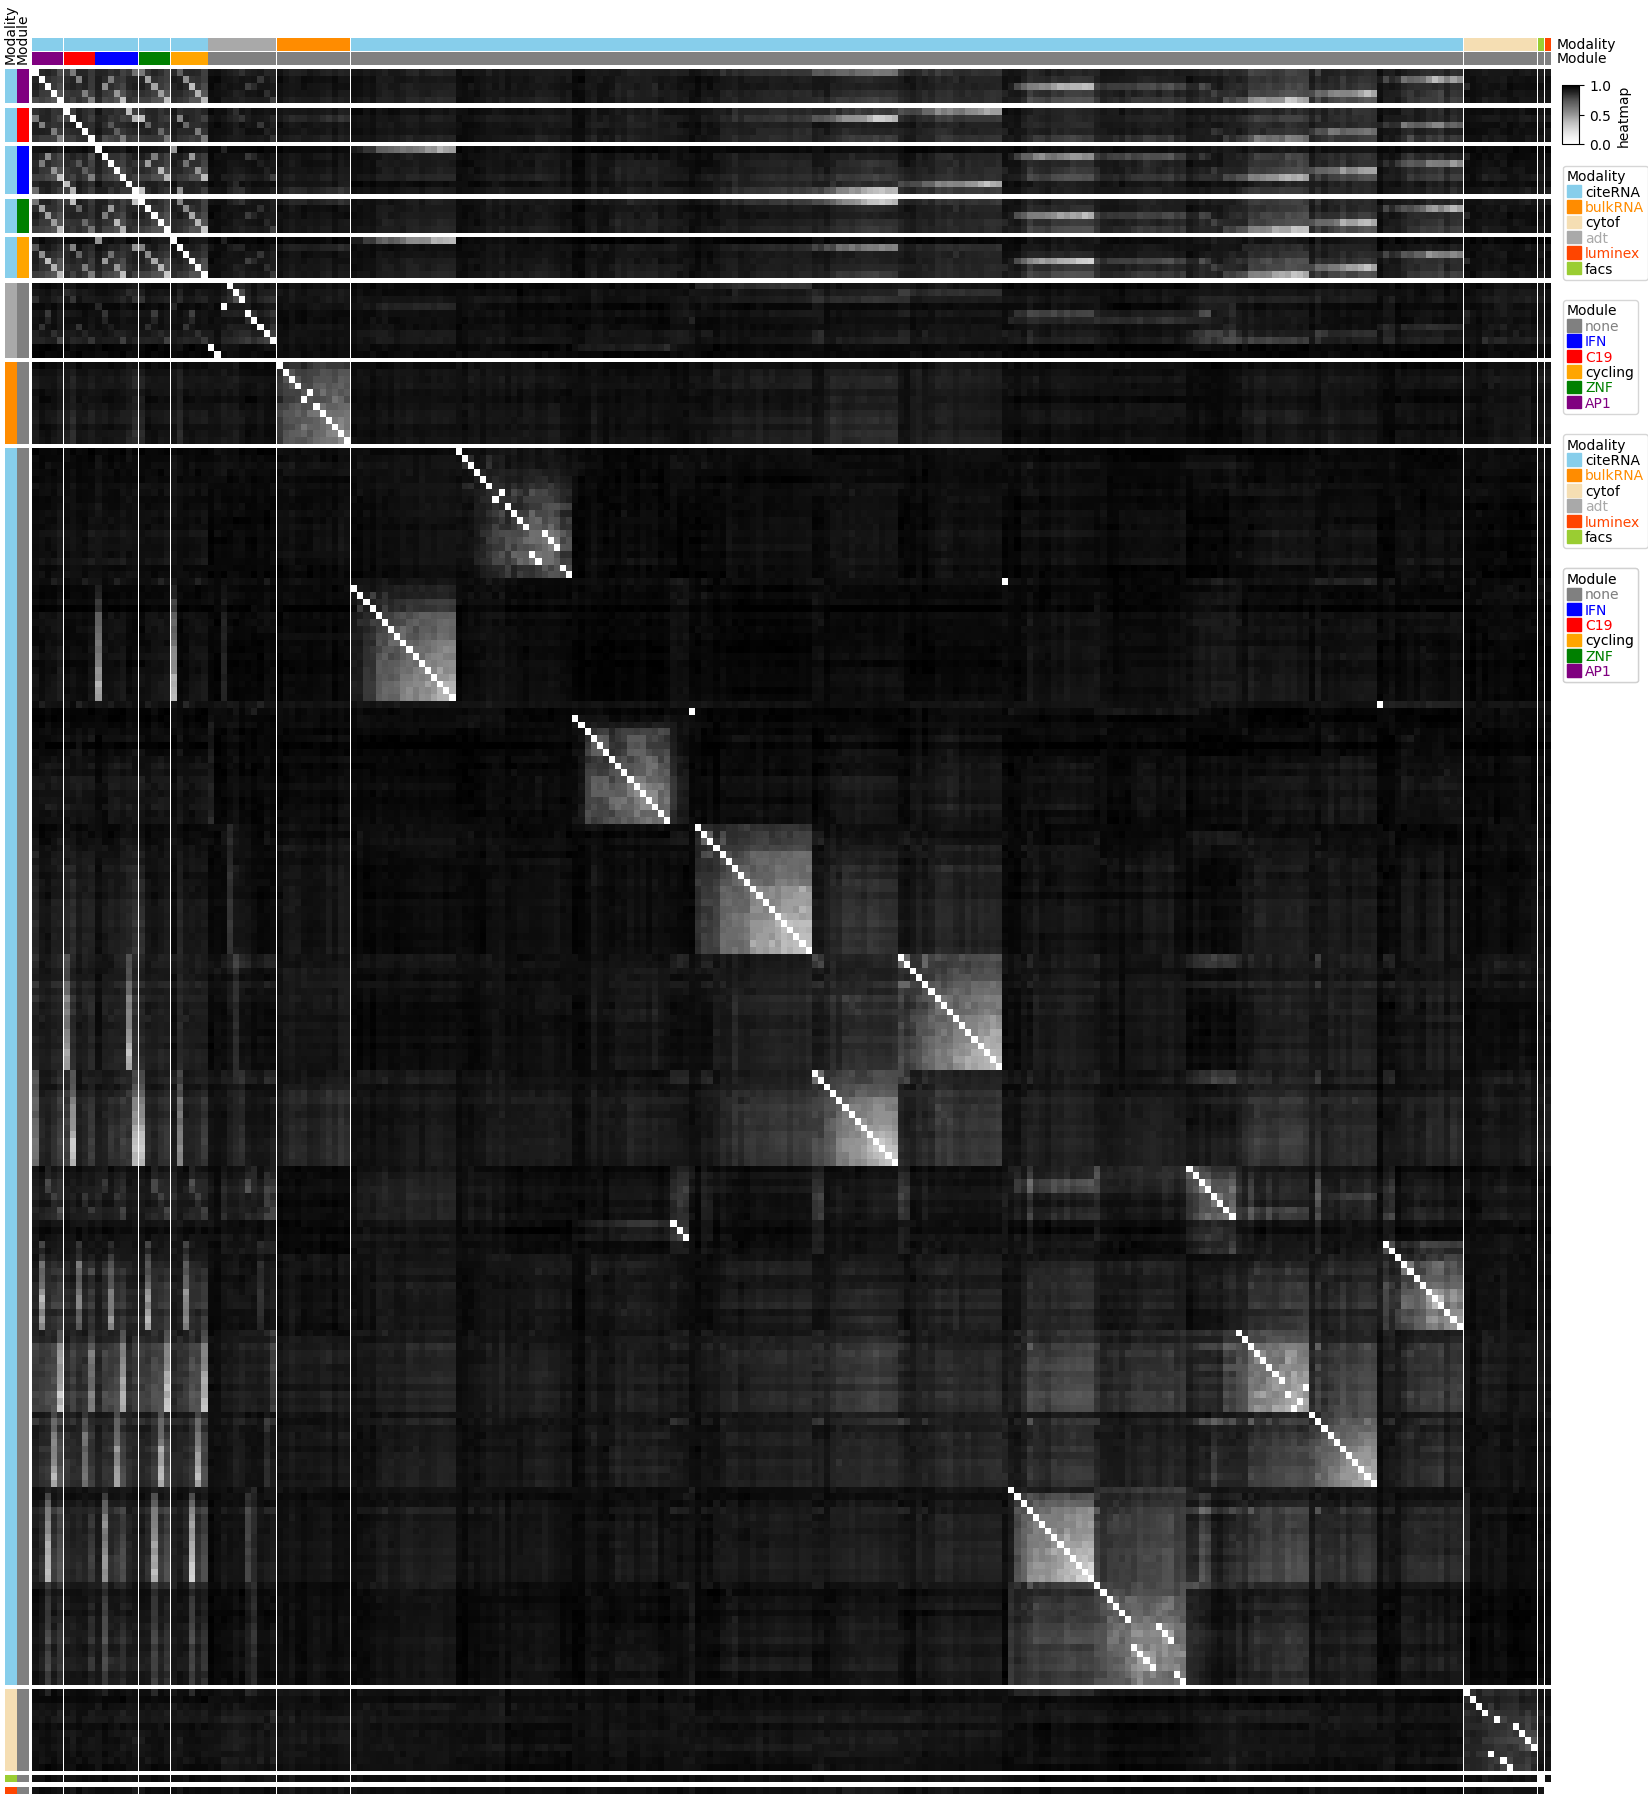

In [ ]:
# Forb norm forb_norm_df
fig, ax = plt.subplots(figsize=(20,20))
forb_norm_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(forb_norm_df)), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
"""forb_norm_sim = {}
for row_index, row in enumerate(forb_norm):
    sim = row.argsort()[1:13]
    forb_norm_sim[id_to_name[sorted_graph_names[row_index]]] = []
    for entry_index in sim:
        id = sorted_graph_names[entry_index]
        name = id_to_name[id]
        forb_norm_sim[id_to_name[sorted_graph_names[row_index]]].append(name)"""

In [ ]:
corr = []

for i, g1 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
    corr_with_g1 = []
    g1 = optimal_psns[g1].copy().flatten()
    for j, g2 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
        g2 = optimal_psns[g2].copy().flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    corr.append(corr_with_g1)

corr = np.array(corr)
corr_df = pd.DataFrame(corr)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


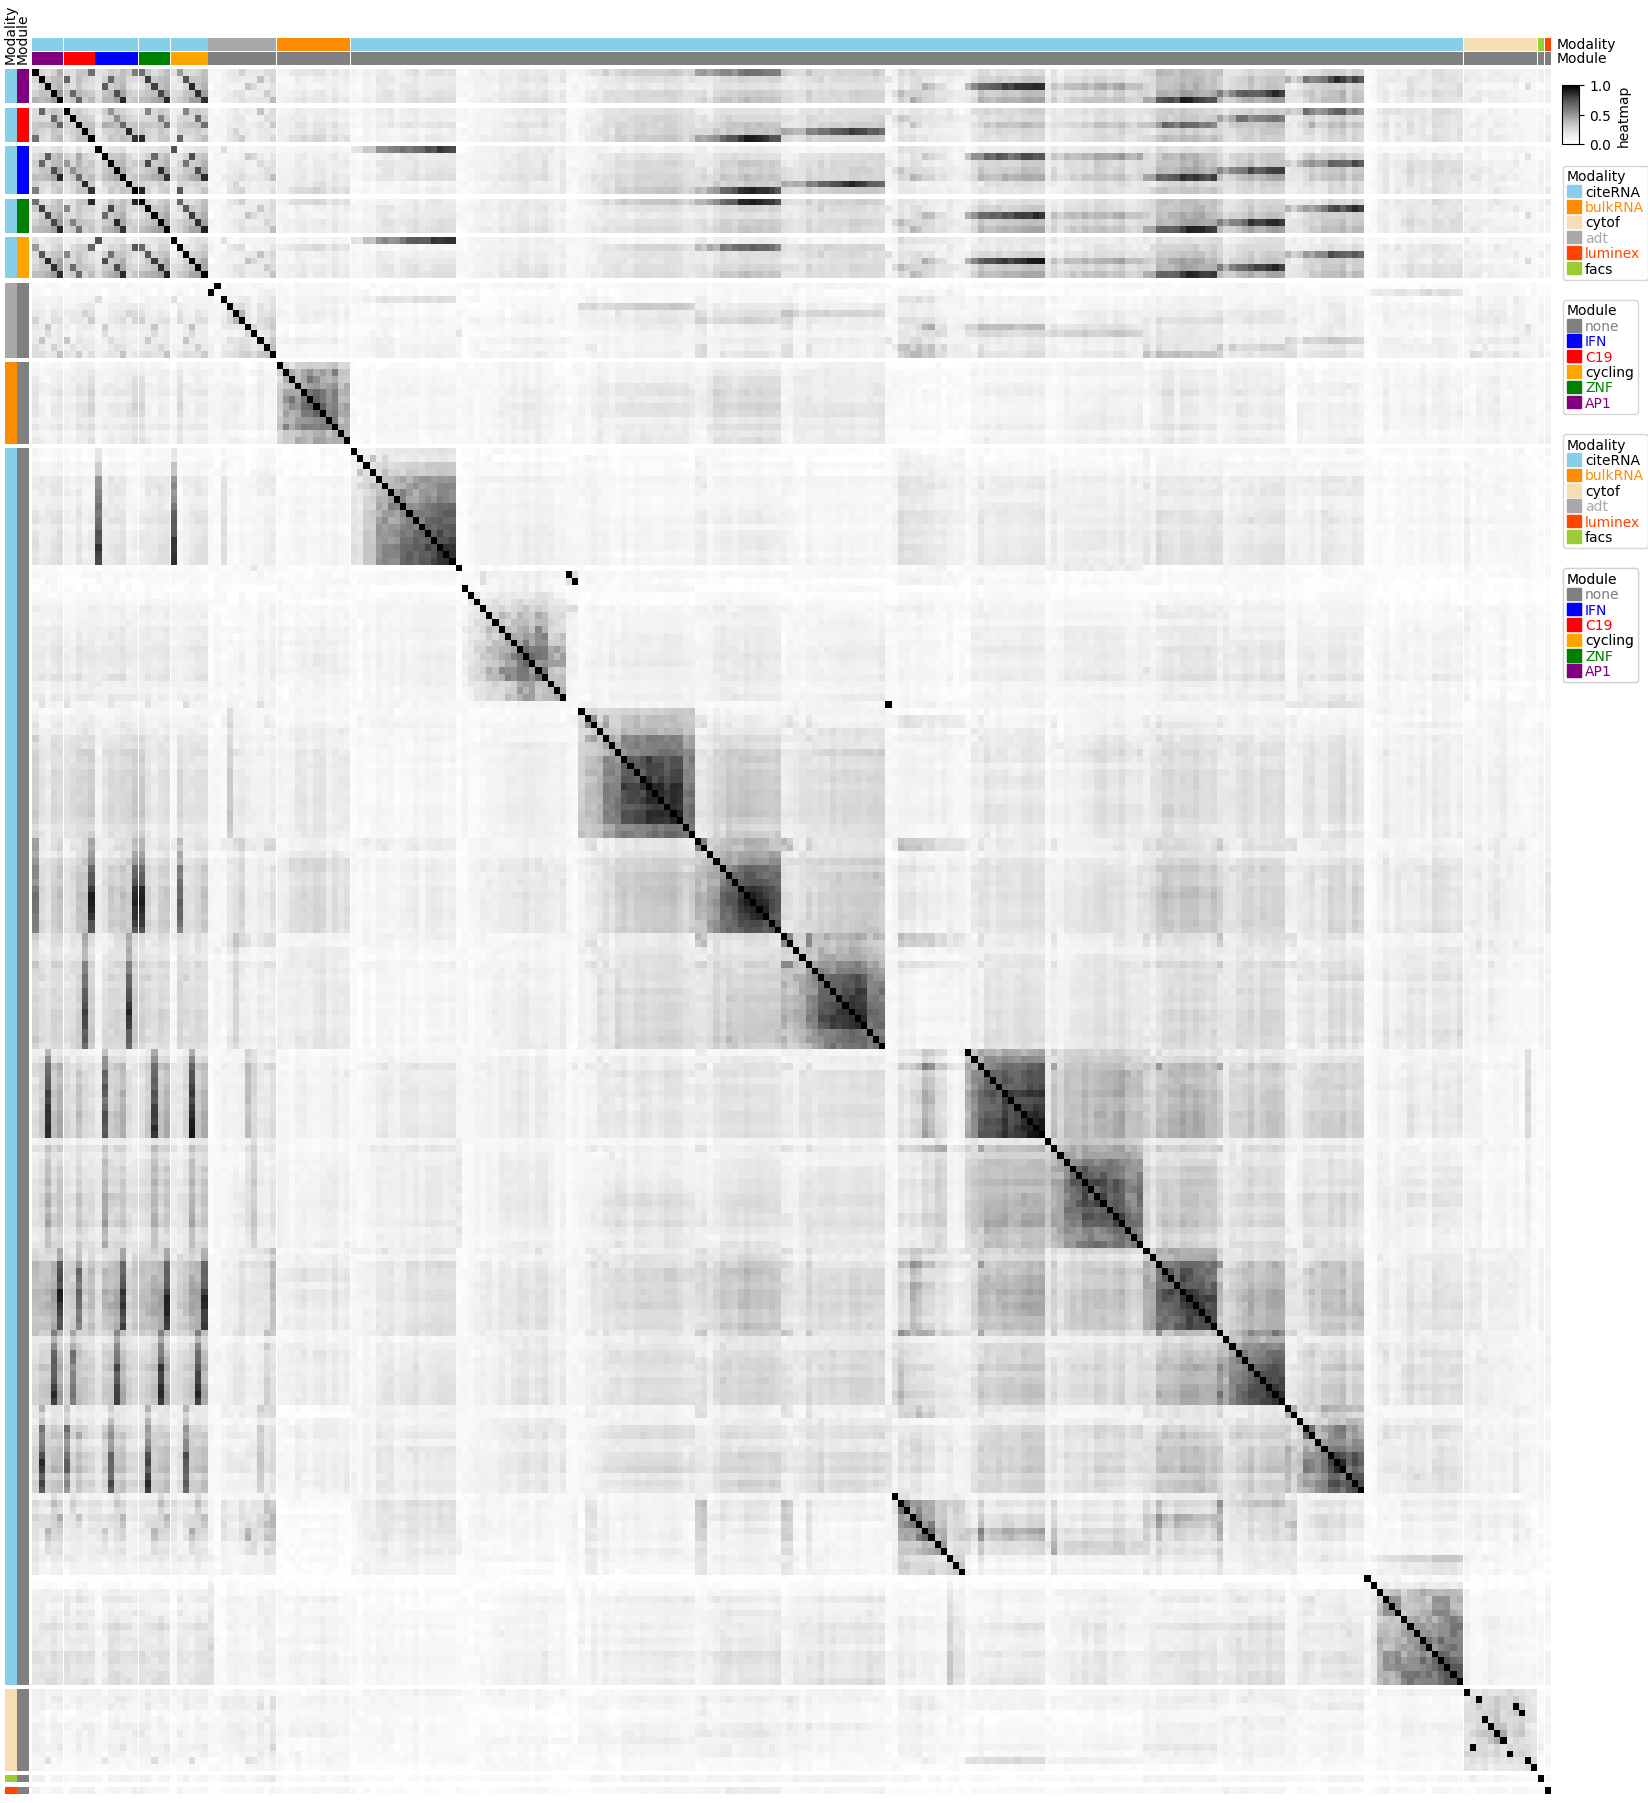

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
corr_df_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(corr_df)), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
"""corr_sim_neg = {}
corr_sim = {}

for row_index, row in enumerate(corr):
    sim = row.argsort()[-10:-1]
    sim_neg = row.argsort()[1:13]
    corr_sim[id_to_name[sorted_graph_names[row_index]]] = []
    corr_sim_neg[id_to_name[sorted_graph_names[row_index]]] = []
    for entry_index in sim:
        id = sorted_graph_names[entry_index]
        name = id_to_name[id]
        corr_sim[id_to_name[sorted_graph_names[row_index]]].append(name)
    for entry_index in sim_neg:
        id = sorted_graph_names[entry_index]
        name = id_to_name[id]
        corr_sim_neg[id_to_name[sorted_graph_names[row_index]]].append(name)"""

In [ ]:
avg_cosine_sim = []
for i, g1 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
    avg_cosine_sim_with_g1 = []
    g1 = optimal_psns[g1].copy()
    for j, g2 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
        g2 = optimal_psns[g2].copy()
        cos_sim = skl.metrics.pairwise.cosine_similarity(g1,g2).mean().mean()
        avg_cosine_sim_with_g1.append(cos_sim)
    avg_cosine_sim.append(avg_cosine_sim_with_g1)

avg_cosine_sim = np.array(avg_cosine_sim)
avg_cosine_sim_df = pd.DataFrame(avg_cosine_sim)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


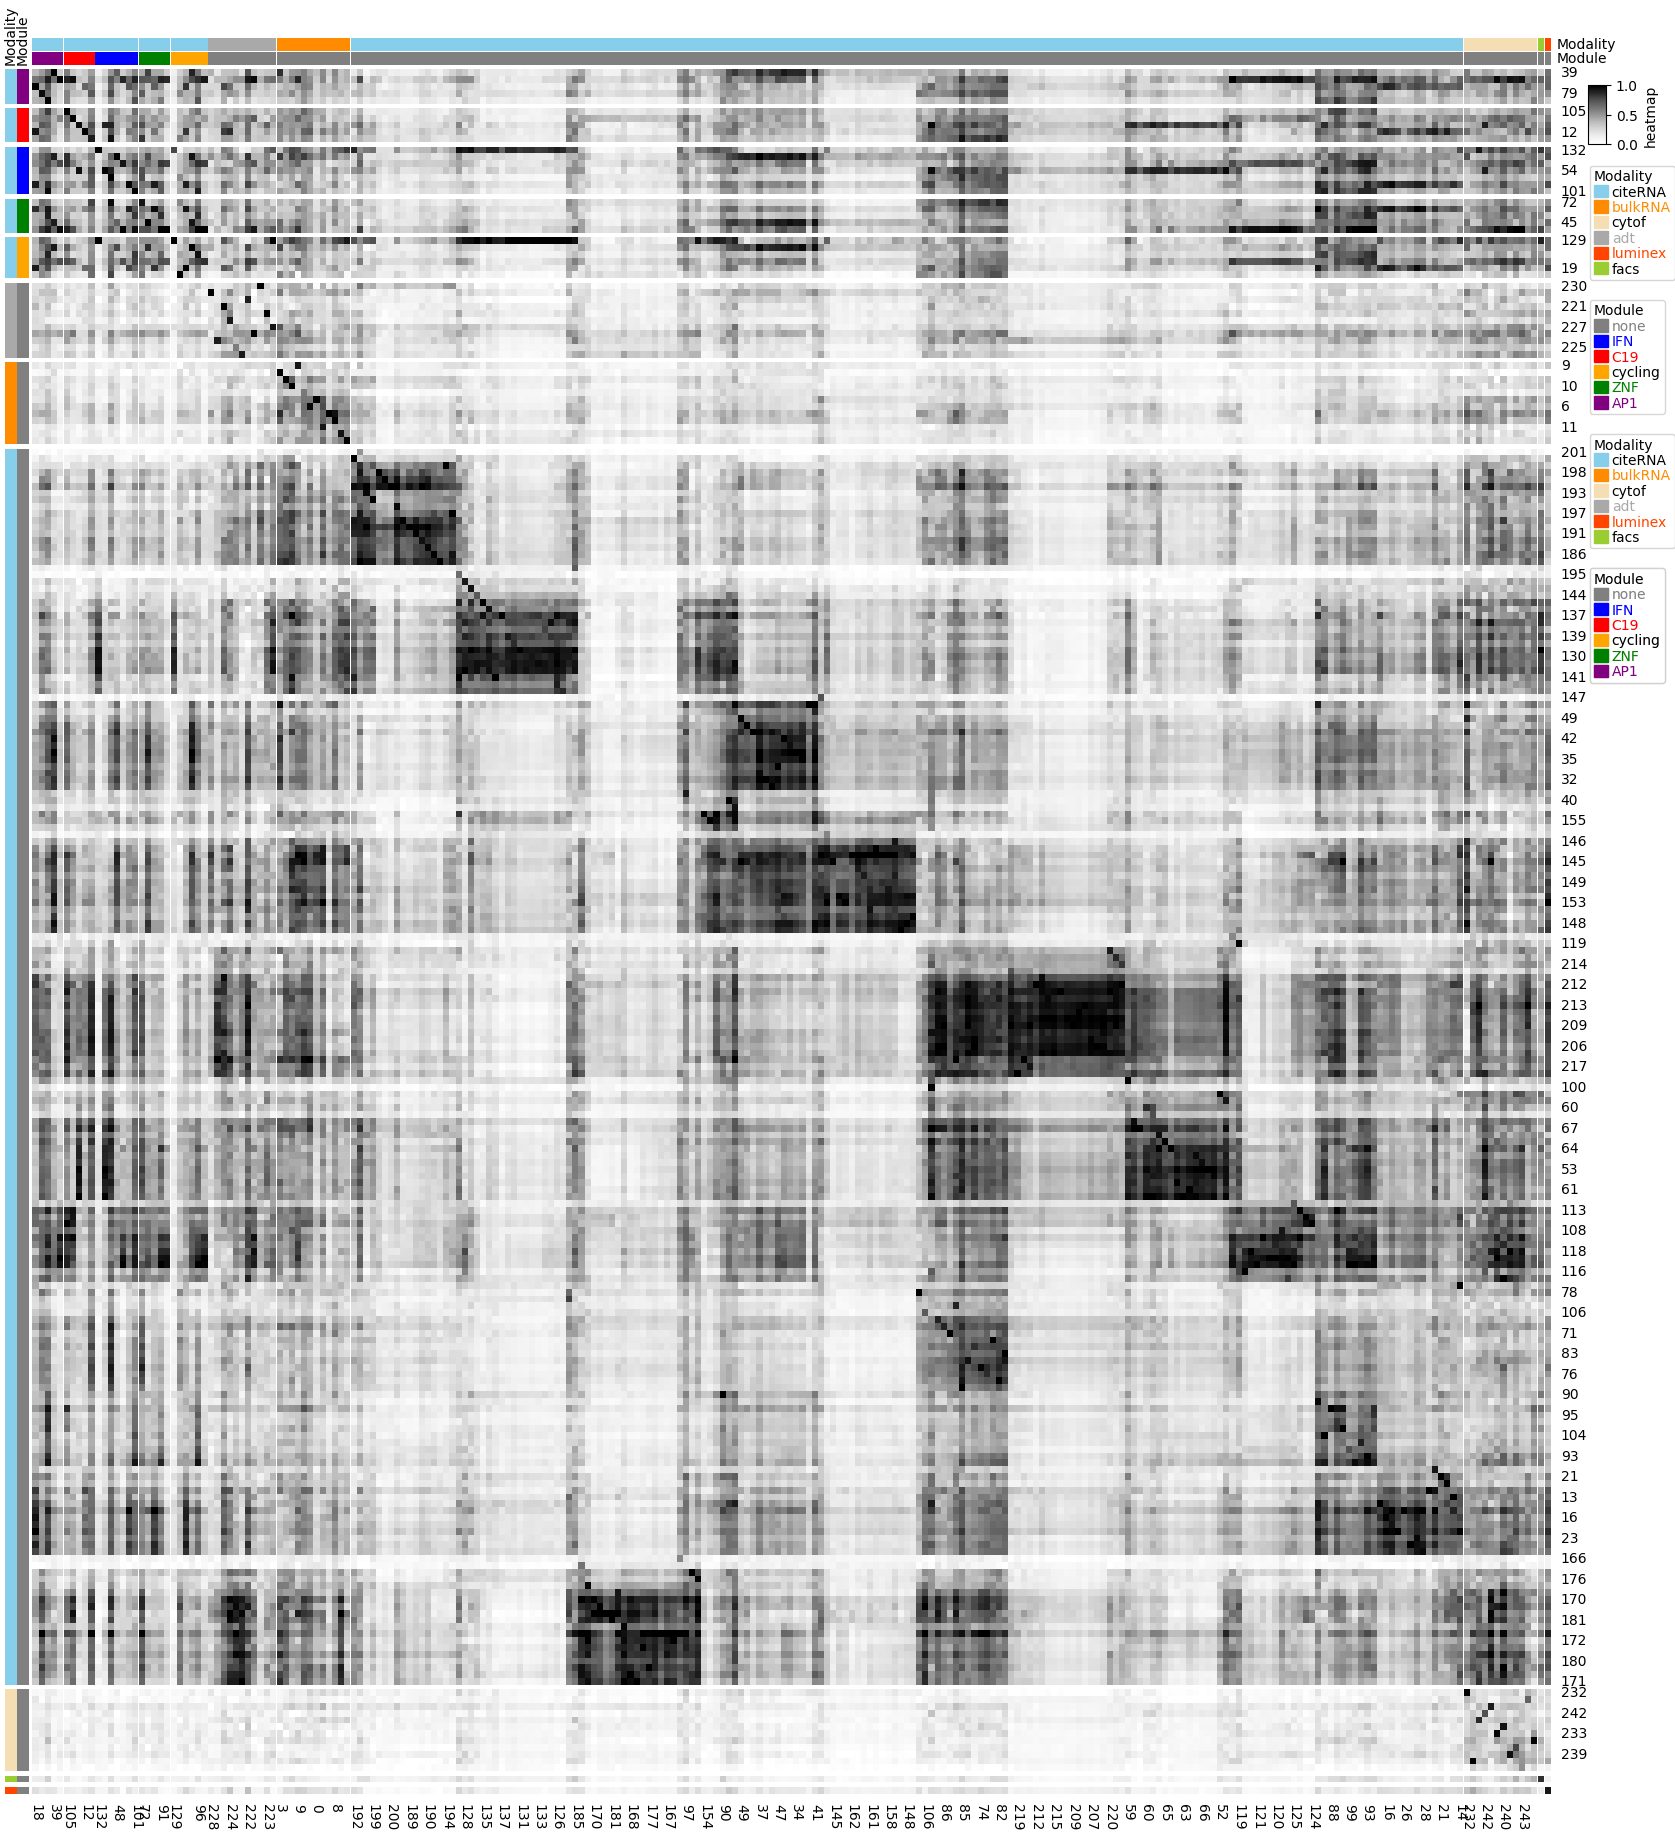

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

avg_cos_sim_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(avg_cosine_sim_df)), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
"""avg_cos_sim_sim = {}
for row_index, row in enumerate(avg_cosine_sim):
    sim = row.argsort()[1:13]
    avg_cos_sim_sim[id_to_name[sorted_graph_names[row_index]]] = []
    for entry_index in sim:
        id = sorted_graph_names[entry_index]
        name = id_to_name[id]
        avg_cos_sim_sim[id_to_name[sorted_graph_names[row_index]]].append(name)"""

{'bulkRNA_greenyellow': ['bulkRNA_turquoise',
  'bulkRNA_cyan',
  'bulkRNA_lightcyan',
  'bulkRNA_blue',
  'bulkRNA_magenta',
  'bulkRNA_green',
  'bulkRNA_purple',
  'bulkRNA_midnightblue',
  'bulkRNA_black',
  'bulkRNA_lightgreen',
  'bulkRNA_grey60',
  'citeRNA_ncMono-midnightblue'],
 'bulkRNA_green': ['bulkRNA_turquoise',
  'bulkRNA_lightcyan',
  'bulkRNA_blue',
  'bulkRNA_greenyellow',
  'bulkRNA_cyan',
  'bulkRNA_purple',
  'bulkRNA_magenta',
  'bulkRNA_black',
  'bulkRNA_lightgreen',
  'bulkRNA_midnightblue',
  'bulkRNA_grey60',
  'citeRNA_cMono-black'],
 'bulkRNA_magenta': ['bulkRNA_lightcyan',
  'bulkRNA_blue',
  'bulkRNA_cyan',
  'bulkRNA_turquoise',
  'bulkRNA_greenyellow',
  'bulkRNA_black',
  'bulkRNA_midnightblue',
  'bulkRNA_lightgreen',
  'bulkRNA_green',
  'bulkRNA_purple',
  'citeRNA_cMono-brown',
  'bulkRNA_grey60'],
 'bulkRNA_lightgreen': ['bulkRNA_cyan',
  'bulkRNA_purple',
  'bulkRNA_turquoise',
  'bulkRNA_lightcyan',
  'bulkRNA_magenta',
  'bulkRNA_blue',
  'bulk

In [ ]:
# compute adjusted mutual information for clustering solutions
labels = [list(sc_knn_labels["snf_fused"]), list(sc_knn_labels["wa_fused"])] 
for id in list(id_to_graphs_with_74_nodes.keys())[:-2]:
     labels.append(list(sc_knn_labels[id]))

ami_sc_knn = []
for l1 in labels:
     l1_amis = []
     for l2 in labels:
          l1_amis.append(ami(l1,l2))
     ami_sc_knn.append(l1_amis)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


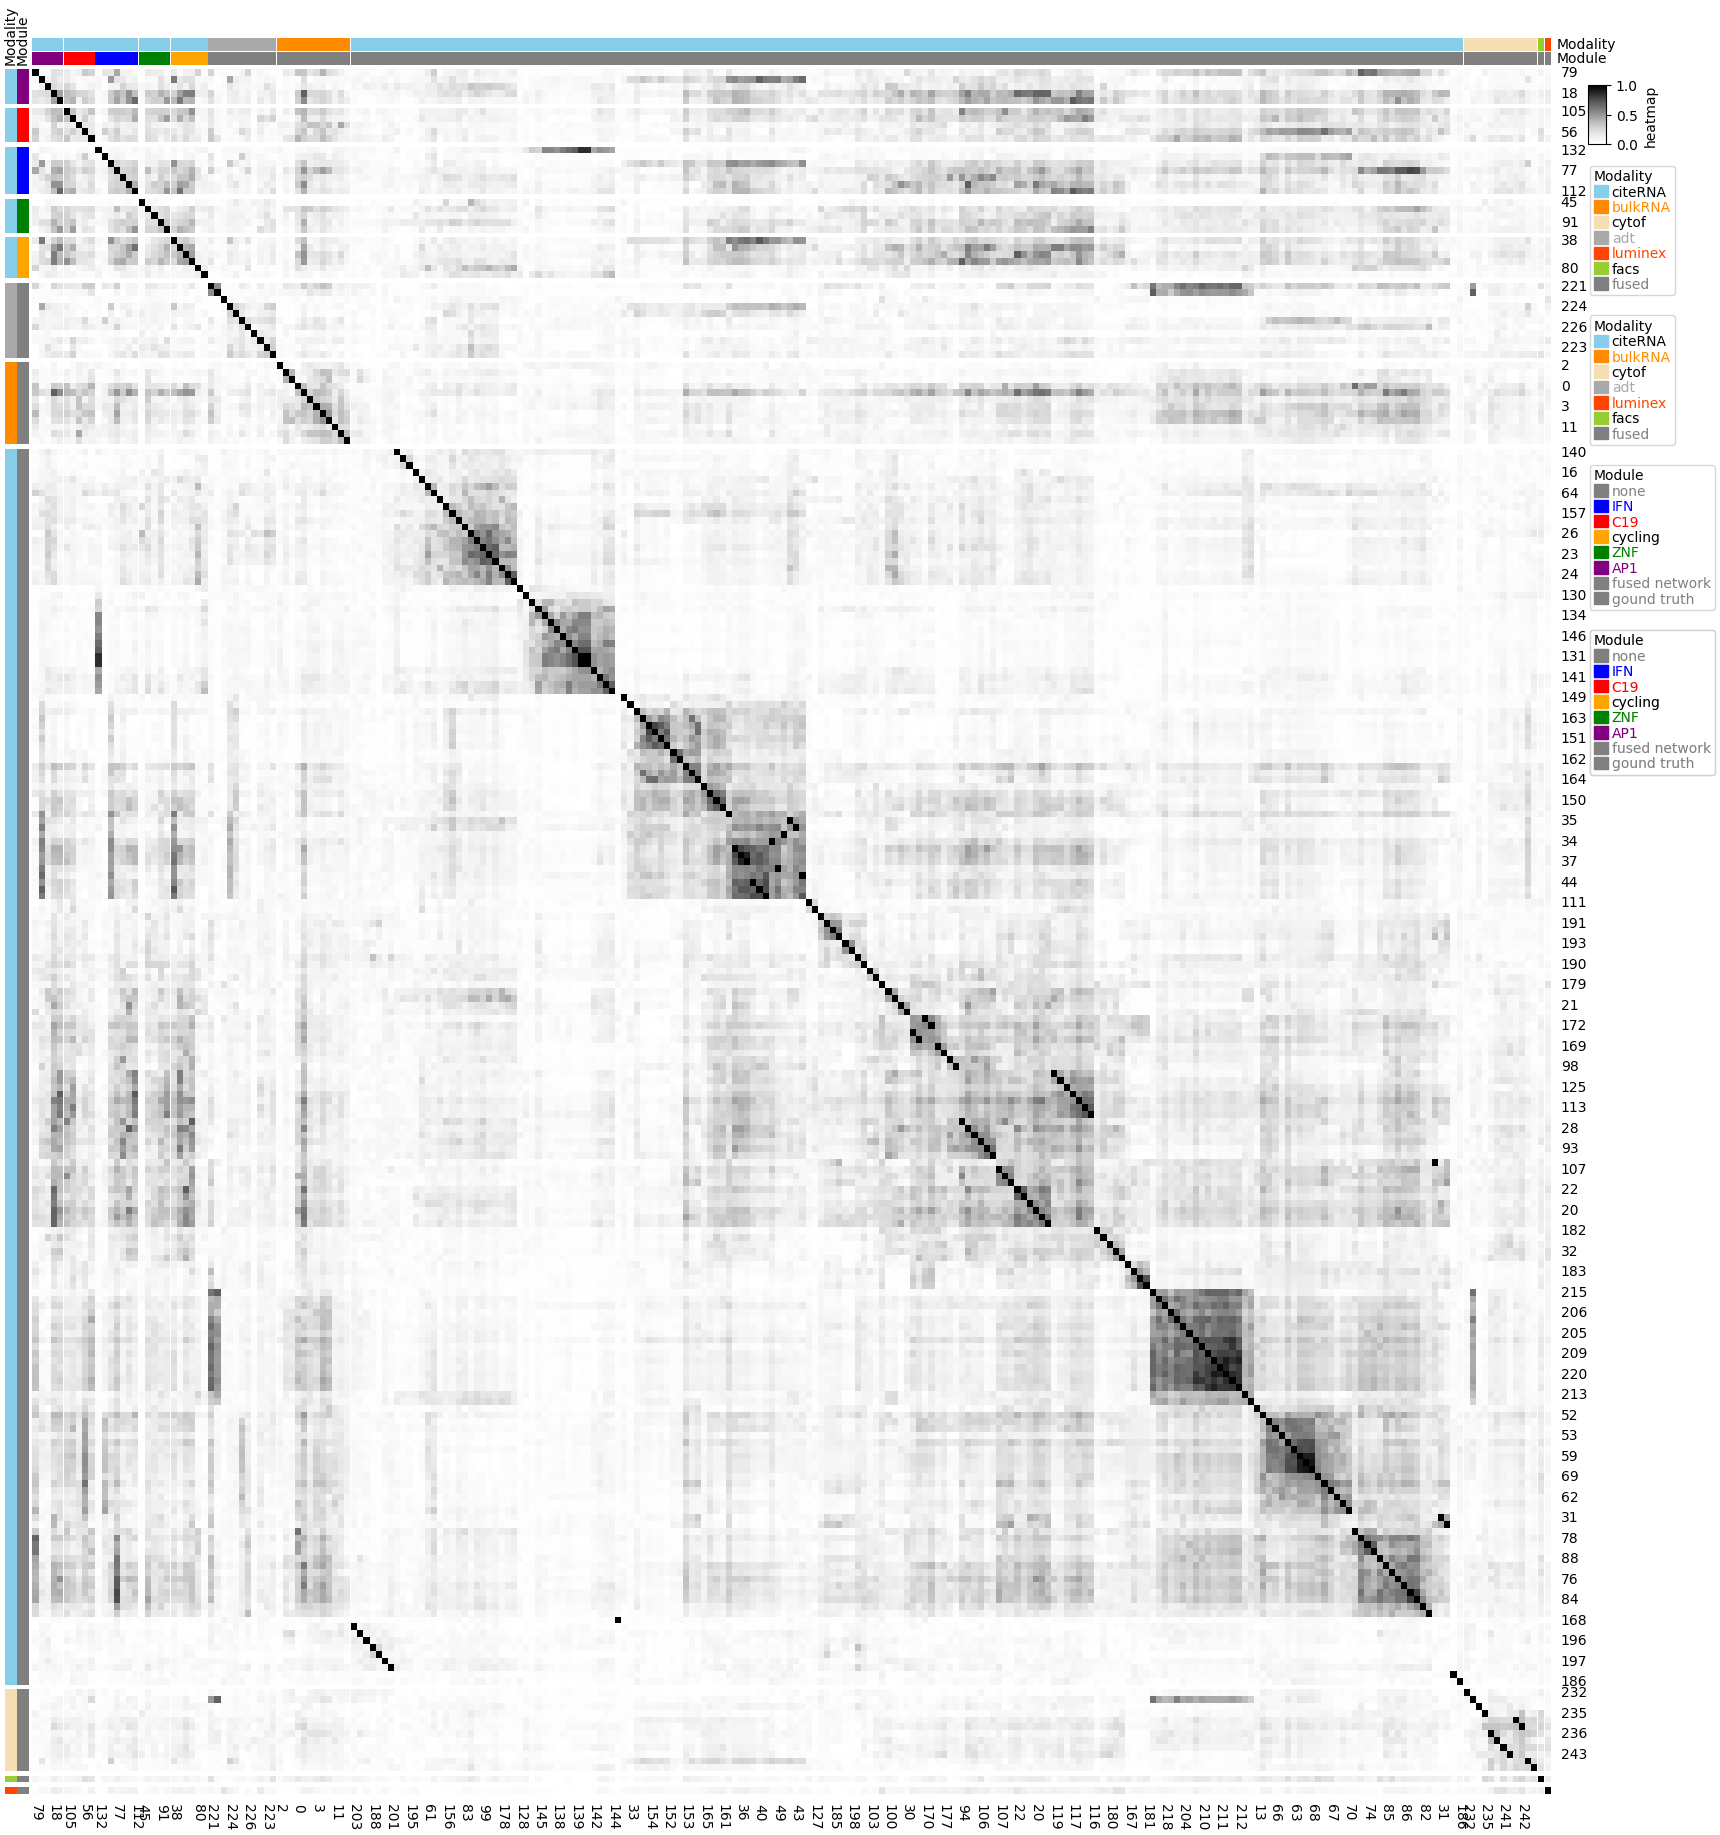

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

ami_sc_knn_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(ami_sc_knn)), top_annotation=col_ha_ami, left_annotation=row_ha_ami,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
# compute adjusted mutual information for clustering solutions
labels = [ list(leiden_knn_labels["snf_fused"]), list(leiden_knn_labels["wa_fused"])] 
for id in list(id_to_graphs_with_74_nodes.keys())[:-2]:
     labels.append(list(leiden_knn_labels[id]))

ami_leiden_knn = []
for l1 in labels:
     l1_amis = []
     for l2 in labels:
          l1_amis.append(ami(l1,l2))
     ami_leiden_knn.append(l1_amis)

Starting plotting..
Starting calculating row orders..
Reordering rows..
Starting calculating col orders..
Reordering cols..
Plotting matrix..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

Starting plotting HeatmapAnnotations
Starting plotting HeatmapAnnotations
Plotting legends..


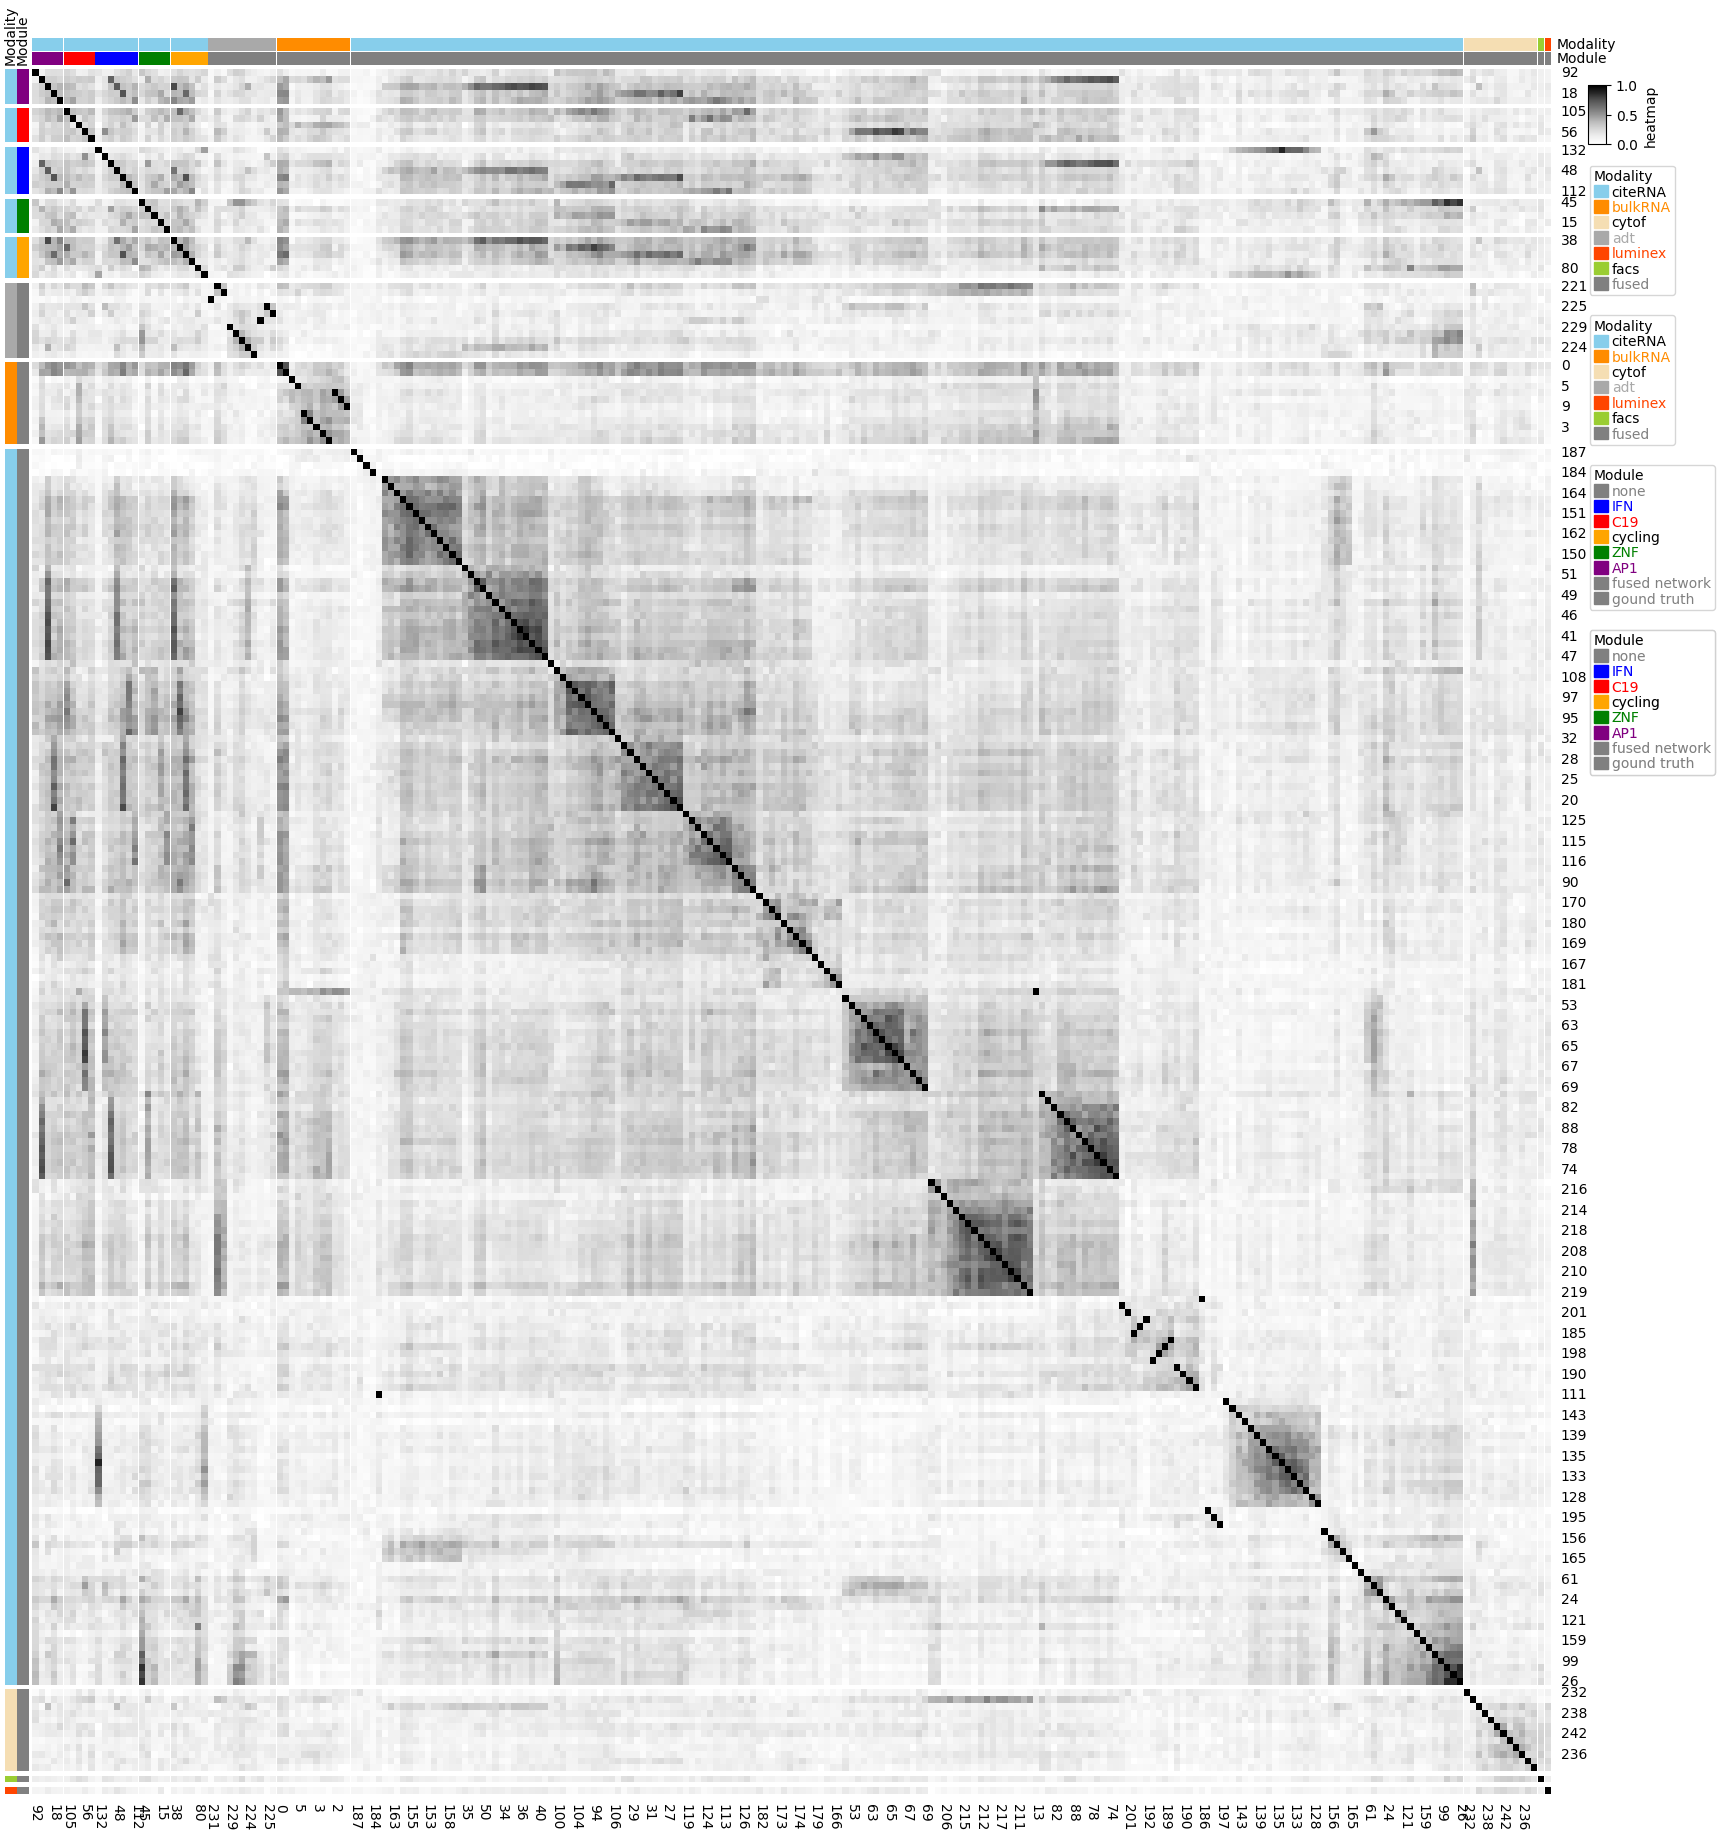

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))

ami_leiden_knn_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(ami_leiden_knn)), top_annotation=col_ha_ami, left_annotation=row_ha_ami,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
"""renamings = {v: k for k,v in renamings.items()}
row_order_names = []

for group in cm.row_order:
    new_group = []
    for graph in group:
        graph = renamings[graph]
        if graph != "fused network" and graph != "gound truth":
            new_group.append(id_to_name[graph])
    row_order_names.append(new_group)
    print(new_group)"""



['citeRNA_CD8-black', 'citeRNA_B-blue', 'citeRNA_cMono-lightcyan', 'citeRNA_CD4-green', 'citeRNA_NK-brown']
['citeRNA_NK-greenyellow', 'citeRNA_B-magenta', 'citeRNA_CD4-midnightblue', 'citeRNA_cMono-green', 'citeRNA_ncMono-brown']
['citeRNA_PB-brown', 'citeRNA_CD8-midnightblue', 'citeRNA_cMono-black', 'citeRNA_ncMono-green', 'citeRNA_B-purple', 'citeRNA_CD4-pink', 'citeRNA_NK-purple']
['citeRNA_CD8-yellow', 'citeRNA_B-turquoise', 'citeRNA_cMono-turquoise', 'citeRNA_CD4-turquoise', 'citeRNA_NK-turquoise']
['citeRNA_PB-turquoise', 'citeRNA_cMono-grey60', 'citeRNA_CD4-black', 'citeRNA_NK-blue', 'citeRNA_B-cyan', 'citeRNA_CD8-blue']
[]
[]
['adt_HSC', 'adt_DC', 'adt_B', 'adt_ncMono', 'adt_GDT', 'adt_NK', 'adt_DP', 'adt_CD4', 'adt_CD8', 'adt_PB', 'adt_cMono']
['bulkRNA_midnightblue', 'bulkRNA_black', 'bulkRNA_lightgreen', 'bulkRNA_green', 'bulkRNA_purple', 'bulkRNA_greenyellow', 'bulkRNA_turquoise', 'bulkRNA_blue', 'bulkRNA_grey60', 'bulkRNA_cyan', 'bulkRNA_magenta', 'bulkRNA_lightcyan']
['c

In [ ]:
"""fig, ax = plt.subplots(3, 1, figsize=(20,20))
sb.heatmap(forb_norm, ax = ax[0], cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8})
ax[0].set_title("forbenius norm")
sb.heatmap(corr, ax = ax[1], cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8})
ax[1].set_title("correlation")
sb.heatmap(avg_cosine_sim, ax = ax[2], cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8})
ax[2].set_title("avg cosine similarity")"""

### Affinities

Starting plotting..
Starting calculating row orders..
Reordering rows..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

KeyError: '[262, 263, 264, 265, 266, 267, 268, 269, 270] not in index'

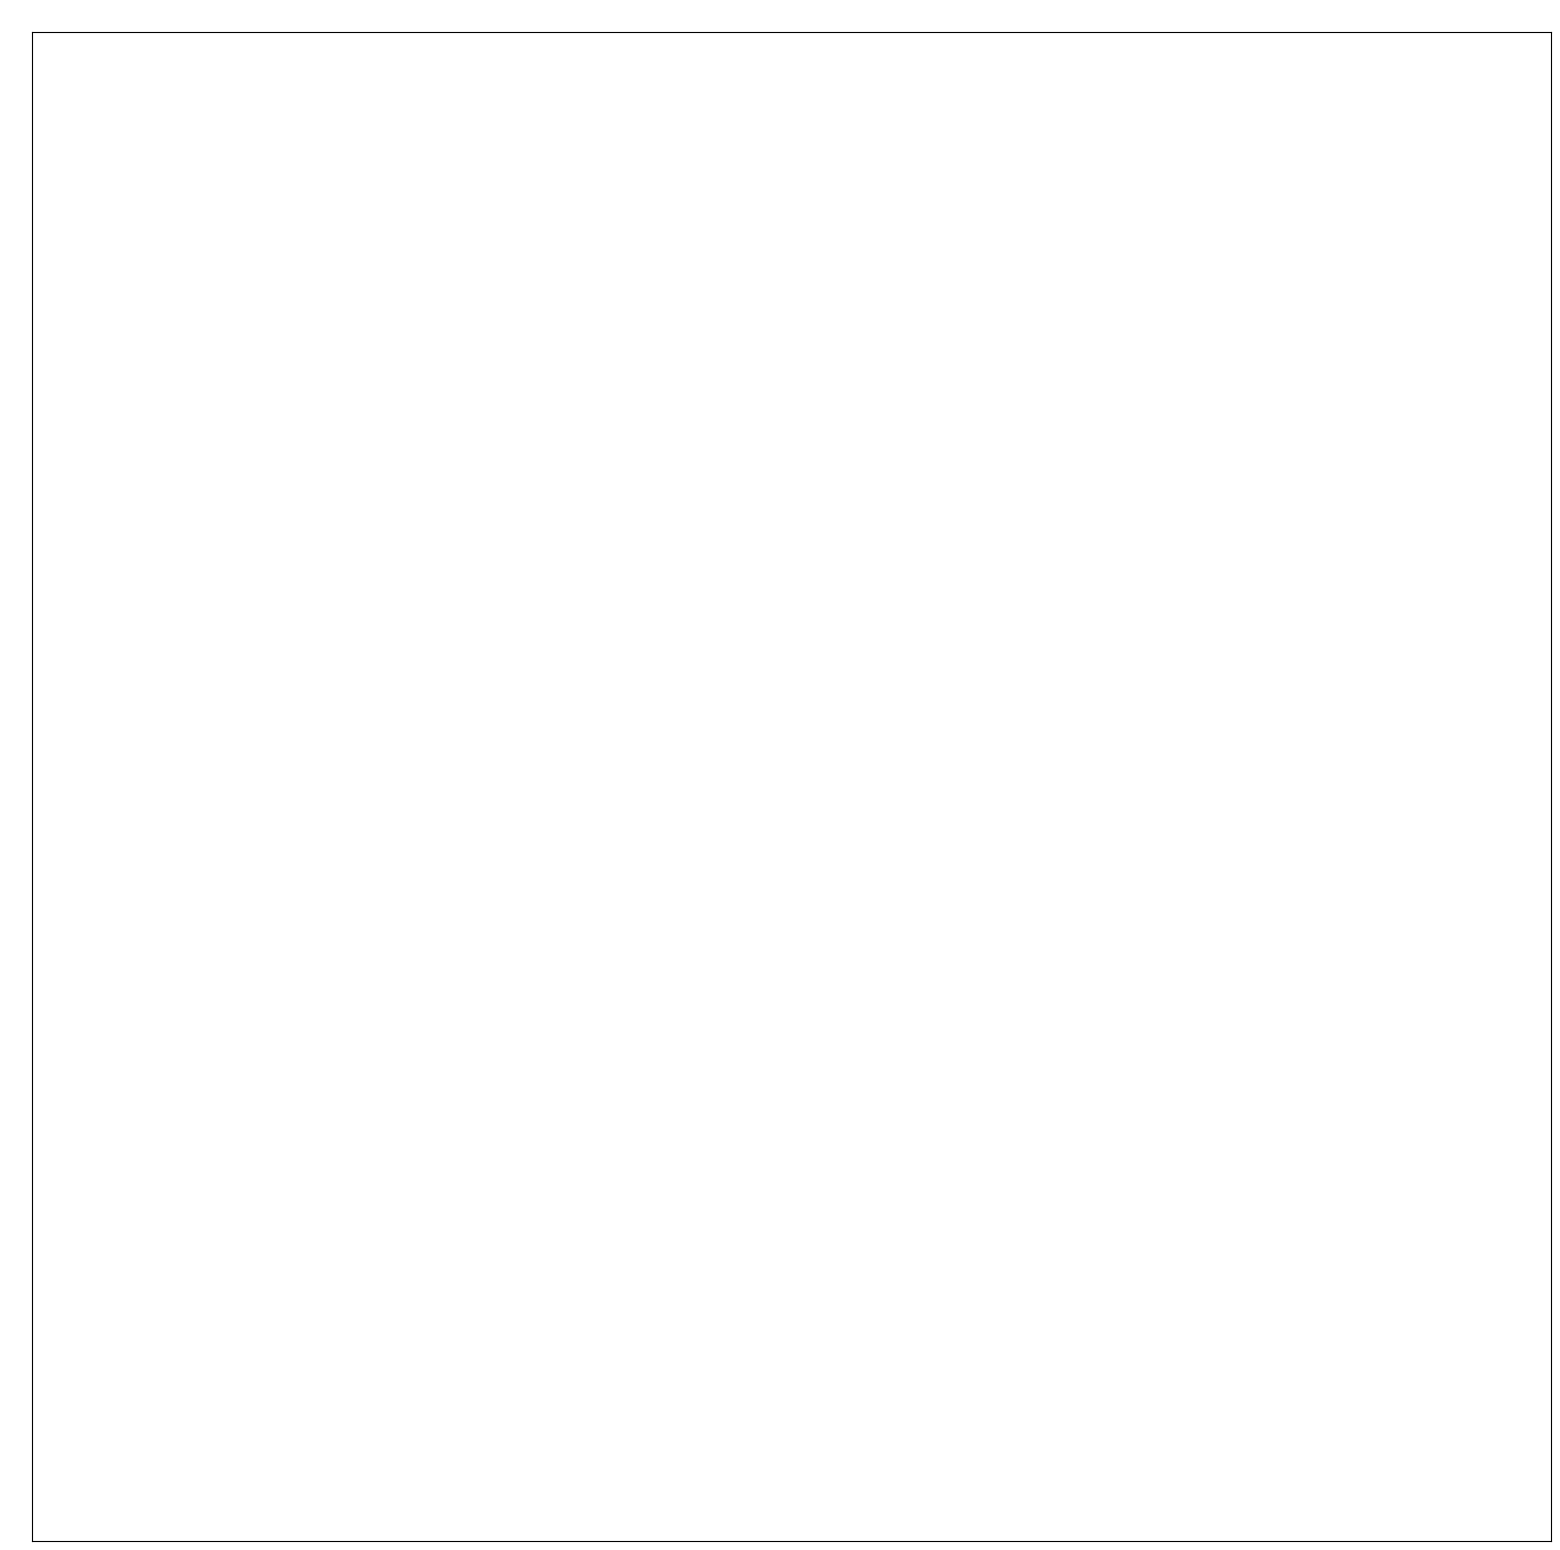

In [ ]:
forb_norm = []

for i, g1 in enumerate(id_to_graphs_with_74_nodes.keys()):
    forb_norm_with_g1 = []

    if g1 != "snf_fused" and g1 != "wa_fused":
        g1 = optimal_affs[g1]
    else:
        continue
    for j, g2 in enumerate(id_to_graphs_with_74_nodes.keys()):
        if g2 != "snf_fused" and g2 != "wa_fused":
            g2 = optimal_affs[g2]
        else:
            continue

        diff = g1 - g2
        norm = np.linalg.norm(diff)
        forb_norm_with_g1.append(norm)

    forb_norm.append(forb_norm_with_g1)

forb_norm = np.array(forb_norm)
forb_norm_aff_df = pd.DataFrame(forb_norm)

# Forb norm forb_norm_df
fig, ax = plt.subplots(figsize=(20,20))
forb_norm_aff_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(forb_norm_aff_df)), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
corr = []

for i, g1 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
    corr_with_g1 = []
    g1 = optimal_affs[g1].flatten()
    for j, g2 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
        g2 = optimal_affs[g2].flatten()
        pearson = np.corrcoef(g1,g2)[0,1]
        corr_with_g1.append(pearson)
    corr.append(corr_with_g1)

corr = np.array(corr)
corr_aff_df = pd.DataFrame(corr)

fig, ax = plt.subplots(figsize=(20,20))
corr_aff_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(corr_aff_df)), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=False,show_colnames=False,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
avg_cosine_sim = []
for i, g1 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
    avg_cosine_sim_with_g1 = []
    g1 = optimal_affs[g1]
    for j, g2 in enumerate(list(id_to_graphs_with_74_nodes.keys())[:-2]):
        g2 = optimal_affs[g2]
        cos_sim = skl.metrics.pairwise.cosine_similarity(g1,g2).mean().mean()
        avg_cosine_sim_with_g1.append(cos_sim)
    avg_cosine_sim.append(avg_cosine_sim_with_g1)

avg_cosine_sim = np.array(avg_cosine_sim)
avg_cosine_sim_aff_df = pd.DataFrame(avg_cosine_sim)

fig, ax = plt.subplots(figsize=(20,20))

avg_cos_sim_aff_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(avg_cosine_sim_aff_df)), top_annotation=col_ha, left_annotation=row_ha,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

Starting plotting..
Starting calculating row orders..
Reordering rows..


/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/PyComplexHeatmap/clustermap.py:636: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/opt/homebrew/Caskroom/miniforge/base/envs/myenv

KeyError: '[248, 249, 250] not in index'

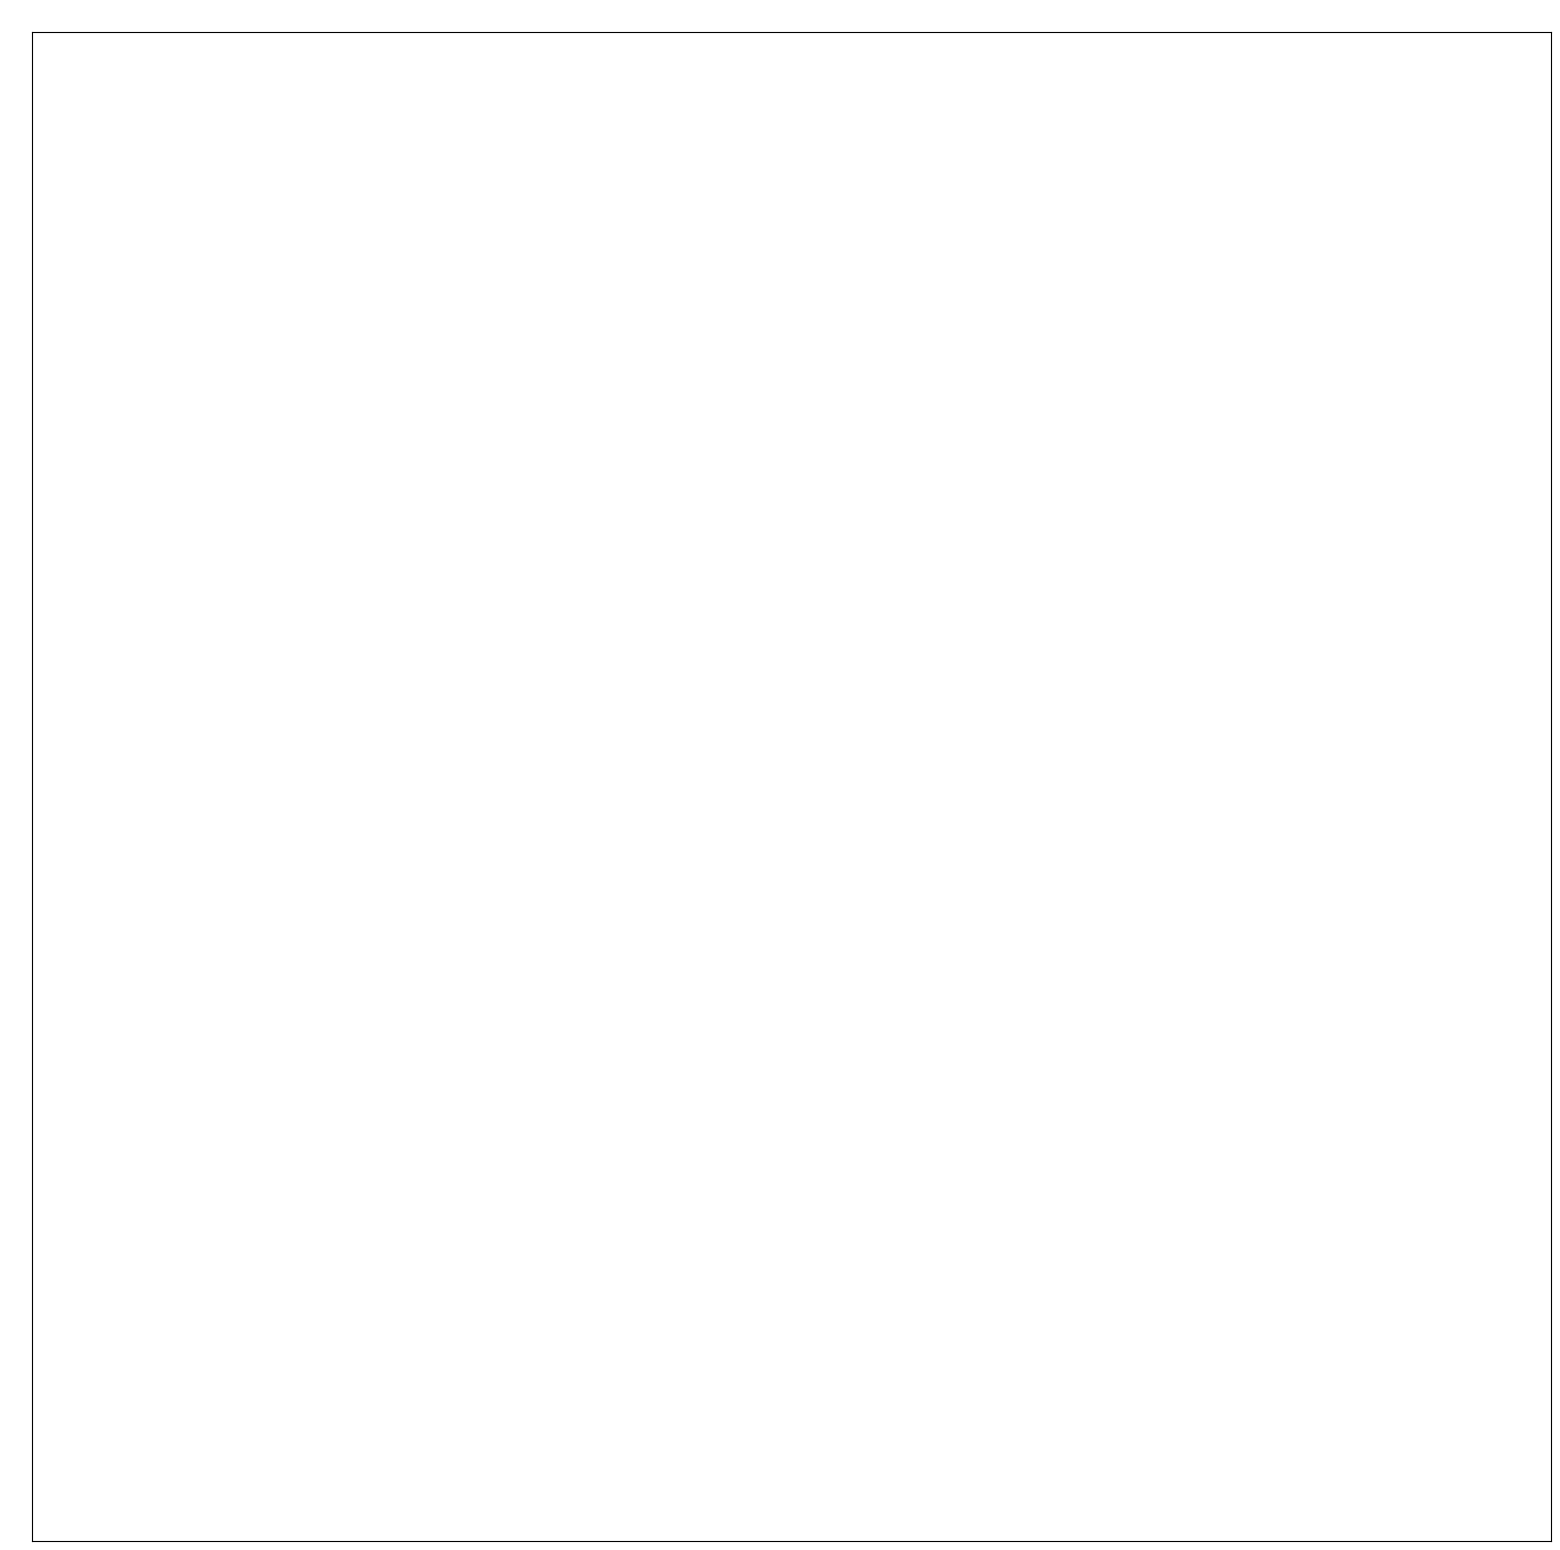

In [ ]:
# compute adjusted mutual information for clustering solutions
labels = [list(sc_kernel_labels["snf_fused"]), list(sc_kernel_labels["wa_fused"])] 
for id in list(id_to_graphs_with_74_nodes.keys())[:-2]:
     labels.append(list(sc_kernel_labels[id]))

ami_sc_kernel = []
for l1 in labels:
     l1_amis = []
     for l2 in labels:
          l1_amis.append(ami(l1,l2))
     ami_sc_kernel.append(l1_amis)

fig, ax = plt.subplots(figsize=(20,20))

ami_sc_kernel_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(ami_sc_kernel)), top_annotation=col_ha_ami, left_annotation=row_ha_ami,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

In [ ]:
# compute adjusted mutual information for clustering solutions
labels = [ list(leiden_kernel_labels["snf_fused"]), list(leiden_kernel_labels["wa_fused"])] 
for id in list(id_to_graphs_with_74_nodes.keys())[:-2]:
     labels.append(list(leiden_kernel_labels[id]))

ami_leiden_kernel = []
for l1 in labels:
     l1_amis = []
     for l2 in labels:
          l1_amis.append(ami(l1,l2))
     ami_leiden_kernel.append(l1_amis)

fig, ax = plt.subplots(figsize=(20,20))

ami_leiden_kernel_plt = ClusterMapPlotter(data=pd.DataFrame(min_max_scalar.fit_transform(ami_leiden_kernel)), top_annotation=col_ha_ami, left_annotation=row_ha_ami,
                     show_rownames=True,show_colnames=True,
                     row_dendrogram=False,col_dendrogram=False,
                     row_split=df_row.loc[:, ['module', 'modality']],
                     col_split=df_column.loc[:, ['module', 'modality']],
                     cmap='Greys',
                     rasterized=True,row_split_gap=1,legend=True,legend_anchor='ax_heatmap',legend_vpad=5)

## Positive Control

### Affinity contribution to ground truth via AMI, Similirty via AMI

### AMI Similarity, Spectral Clustering Over ane Under-Contibution, Kernel

Text(0.5, 1.0, 'Correlation of low 5% 4NN-based PSNs with a structure similar to the optimal one')

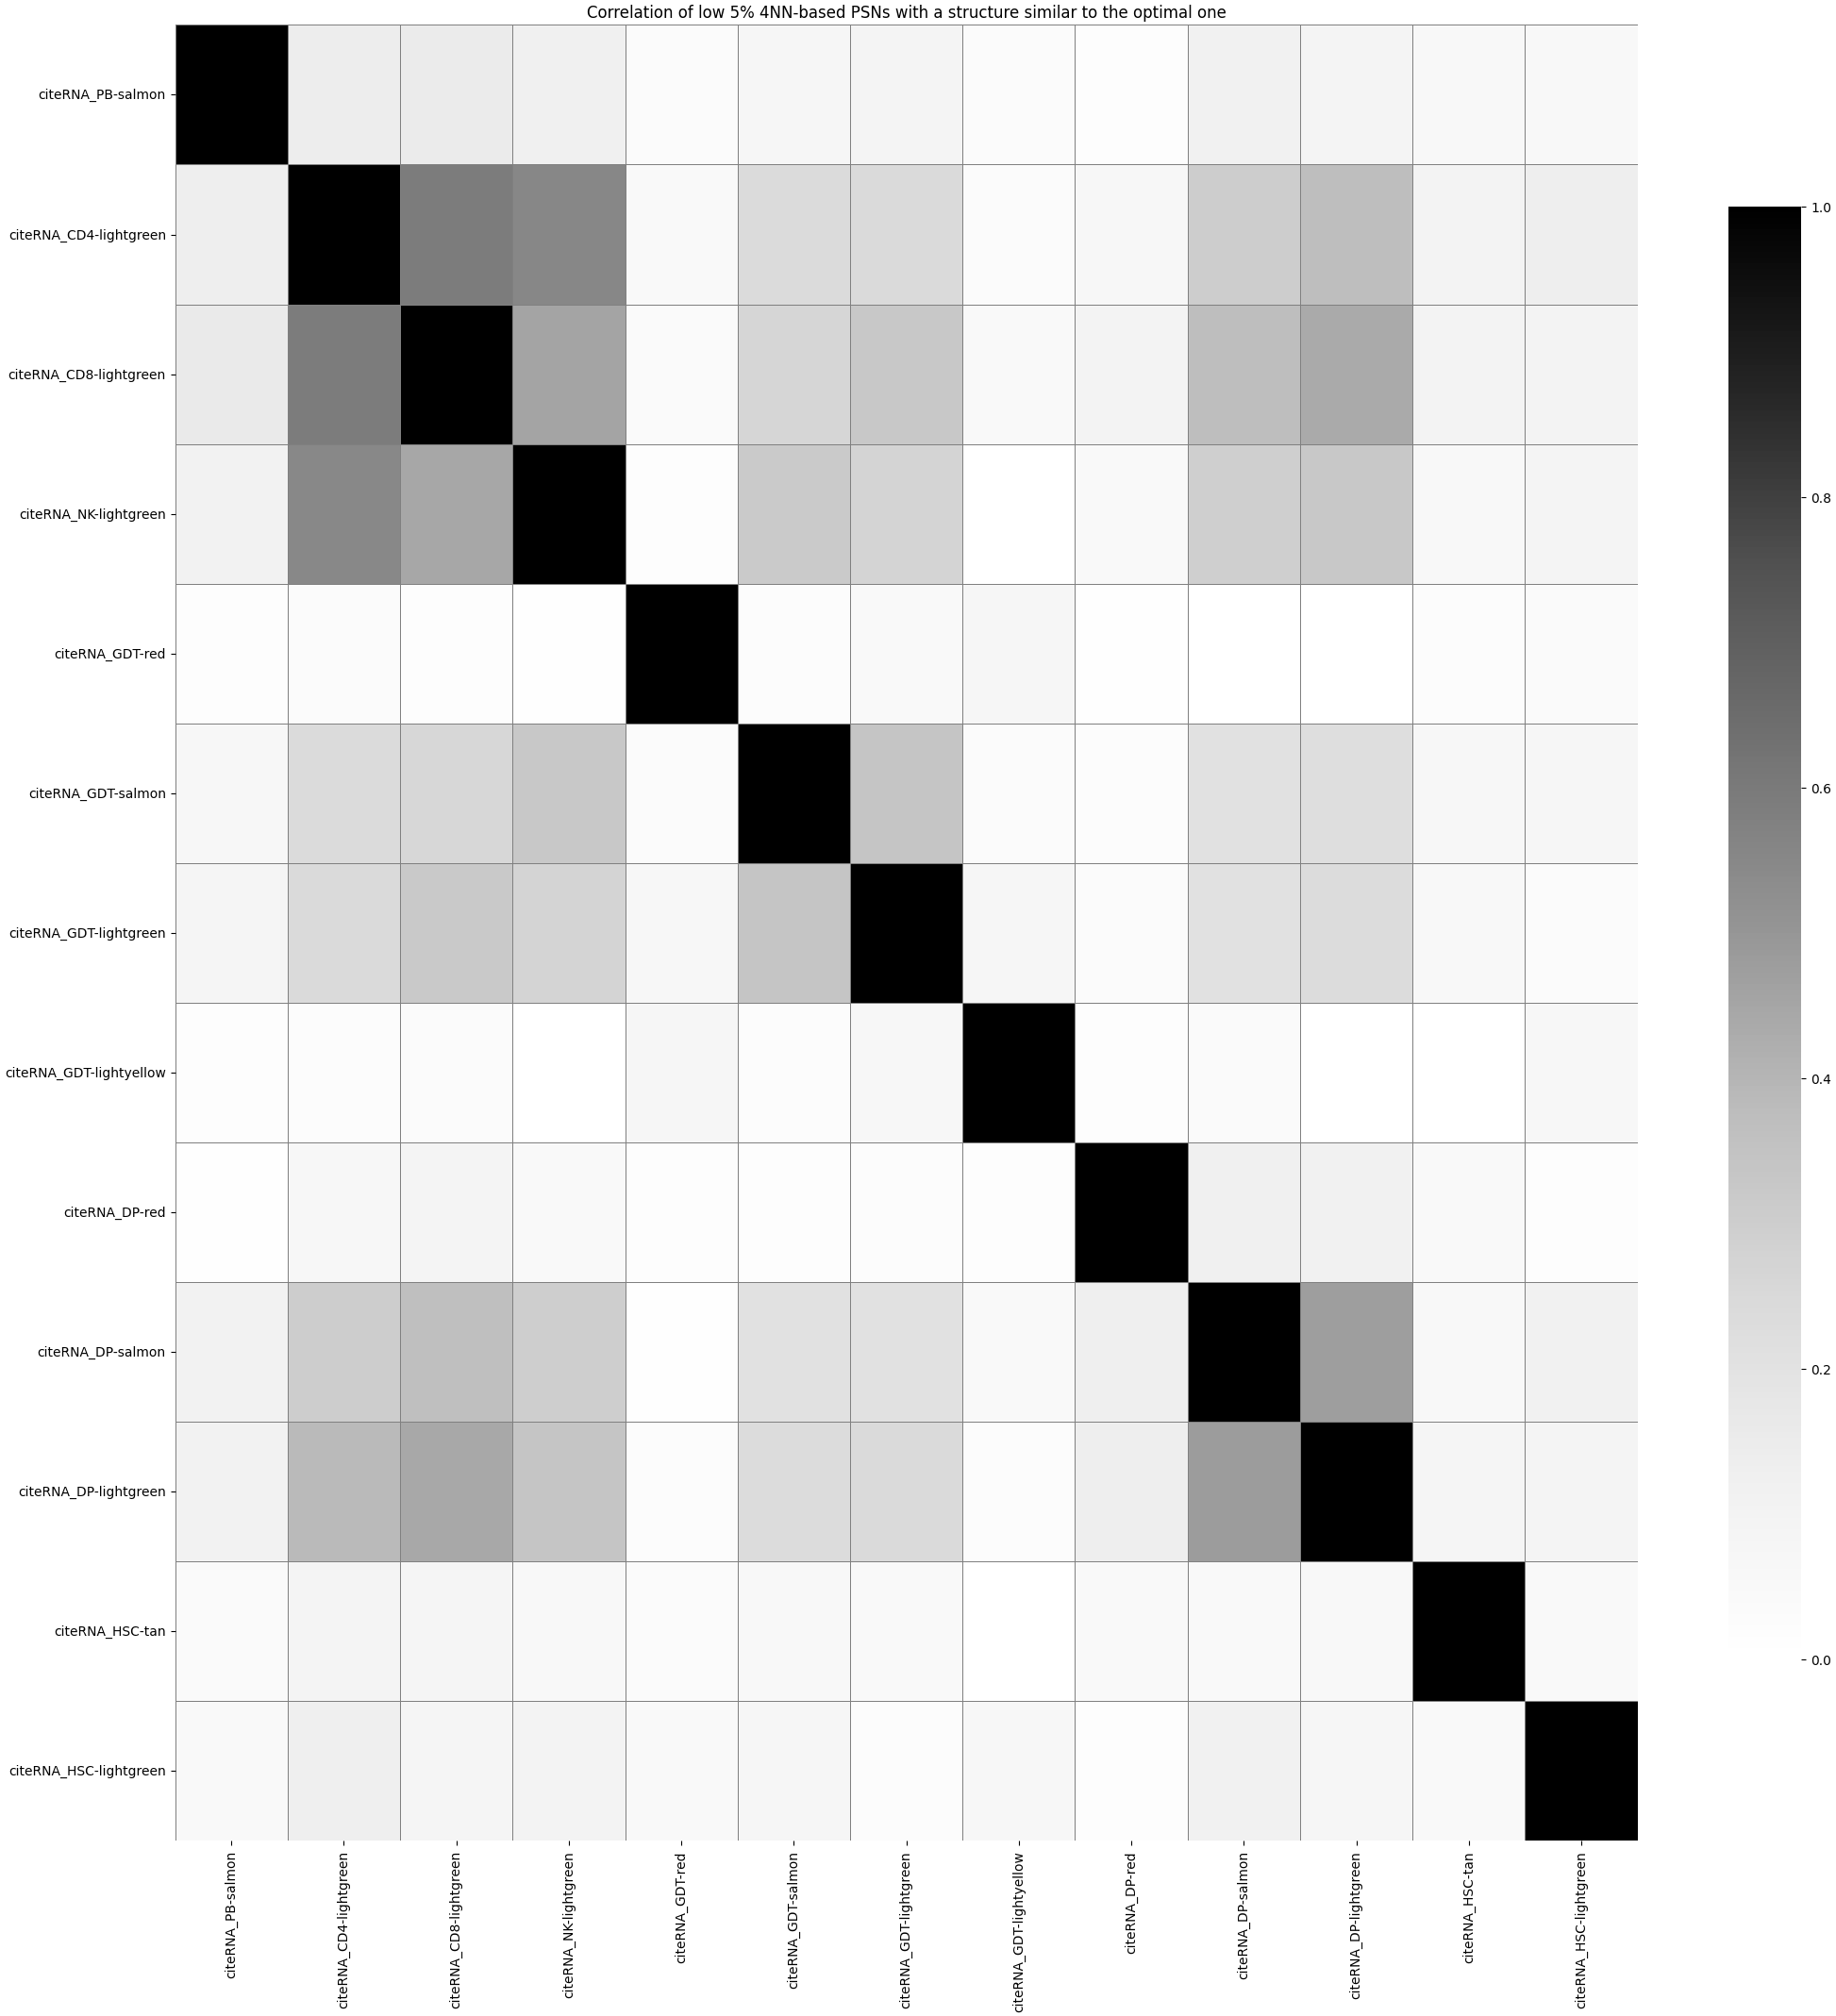

In [ ]:
fig, ax = plt.subplots(figsize=(25,25))
sb.heatmap(corr_df_with_names[low_5pct_PSNgraphs_closeness_to_opt].transpose()[low_5pct_PSNgraphs_closeness_to_opt], ax = ax, cmap = "Greys", robust = False, linewidth=.5, linecolor = "grey", cbar_kws={"shrink": 0.8}, cbar = True)
ax.set_title("Correlation of low 5% 4NN-based PSNs with a structure similar to the optimal one")